<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])];
t_save = [solver.sim_time];
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s


2025-11-20 09:23:35,178 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s


INFO:__main__:Starting main loop


2025-11-20 09:23:35,184 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-20 09:23:35,358 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2025-11-20 09:23:35,361 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2025-11-20 09:23:35,364 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.2693 sec


2025-11-20 09:23:35,367 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2693 sec


INFO:solvers:Warmup time (iter 0-10): 0.04191 sec


2025-11-20 09:23:35,370 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.04191 sec


INFO:solvers:Run time (iter 10-end): 0.1336 sec


2025-11-20 09:23:35,372 solvers 0/1 INFO :: Run time (iter 10-end): 0.1336 sec


INFO:solvers:CPU time (iter 10-end): 3.711e-05 cpu-hr


2025-11-20 09:23:35,374 solvers 0/1 INFO :: CPU time (iter 10-end): 3.711e-05 cpu-hr


INFO:solvers:Speed: 1.377e+06 mode-stages/cpu-sec


2025-11-20 09:23:35,375 solvers 0/1 INFO :: Speed: 1.377e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-20 09:23:35,459 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp62bj2tgh/temp.m4v


2025-11-20 09:23:35,462 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp62bj2tgh/temp.m4v


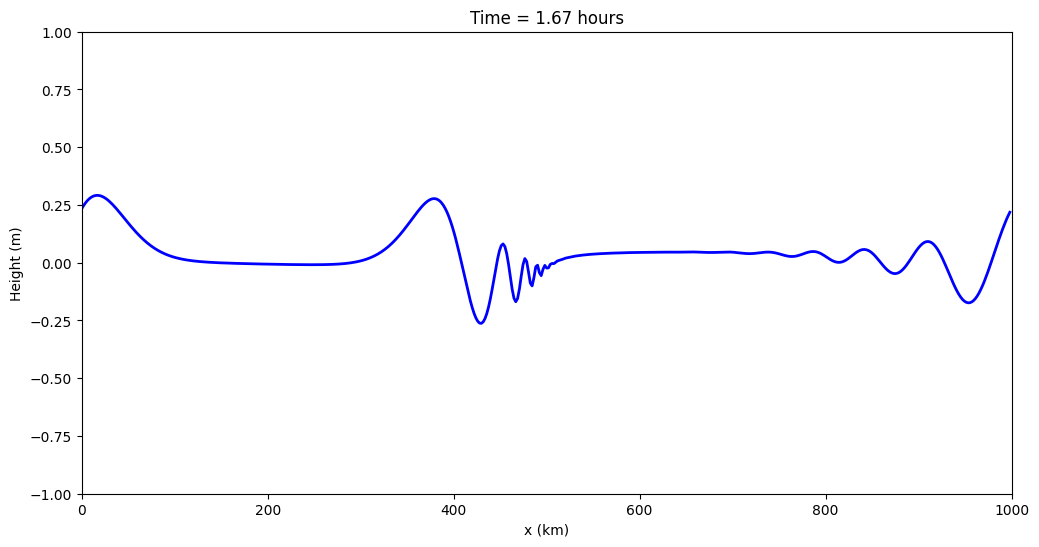

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.


$$ \dfrac{\partial u}{\partial t} + g \dfrac{\partial h}{\partial x} = - u\dfrac{\partial u}{\partial x}$$
$$ \dfrac{\partial h}{\partial t} + H\dfrac{\partial u}{\partial x} = -\partial_x(hu)$$

Starting with the provided equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

We assume h << H, linearize, and solve for a common $\partial_{xt}(u)$ by taking the derivative of the top equation with regards to x, and the bottom with regards to t.

$$ \partial_{xt} u + g \partial_{xx}h = 0$$
$$ \partial_{tx} u =- g \partial_{xx}h$$
$$ \partial_{tt} h + H\partial_{tx}u = 0$$

$$ \partial_{tt} h + -gH\partial_{xx}h = 0$$
$$ \partial_{tt} h = gH\partial_{xx}h $$



which leads to a wave propogating with speed $c=\sqrt{gH}$


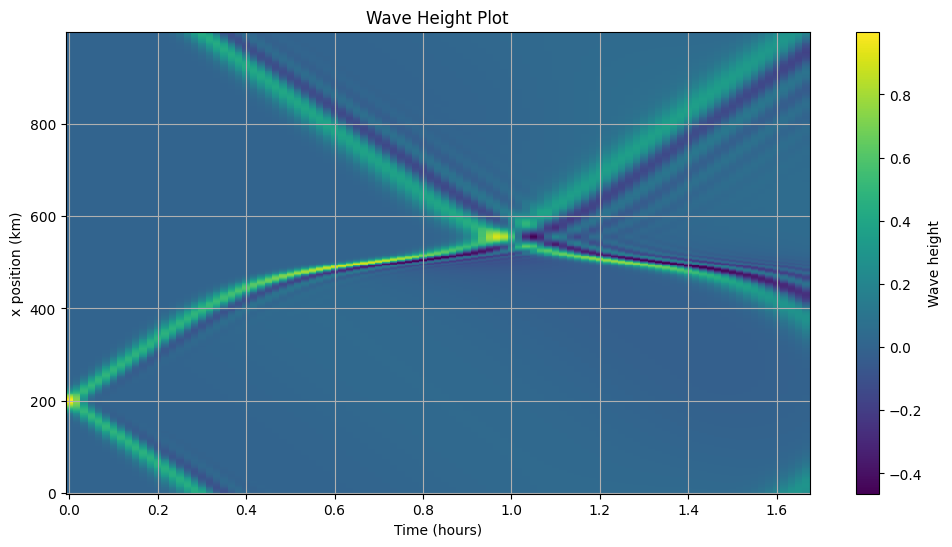

In [ ]:
# used gemini to help generate plot
plt.figure(figsize=(12, 6))
plt.pcolormesh(np.array(t_save) / hour, x / kilometer, h_save.T, shading='auto', cmap='viridis')
plt.colorbar(label='Wave height')
plt.xlabel('Time (hours)')
plt.ylabel('x position (km)')
plt.title('Wave Height Plot')
plt.grid(True)
plt.show()

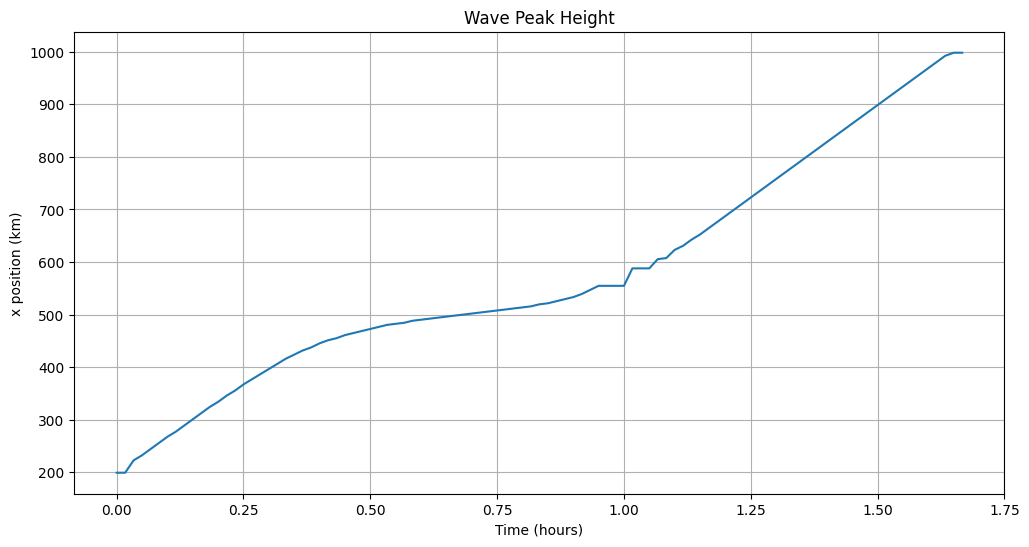

In [ ]:

wave_position = []
prev = 0

for timestep in h_save:
    # We only allow the wave to monotonically increase to ignore the extraneous wave moving backwards
    x_pos_of_peak = np.argmax(timestep[prev:]) + prev
    wave_position.append(x_pos_of_peak)
    prev = x_pos_of_peak

x_pos_of_wave = np.float64(wave_position)* kilometer / len(h_save[1])

plt.figure(figsize=(12, 6))
plt.plot(np.array(t_save) / hour, x_pos_of_wave)
plt.xlabel('Time (hours)')
plt.ylabel('x position (km)')
plt.title('Wave Peak Height')
plt.grid(True)
plt.show()



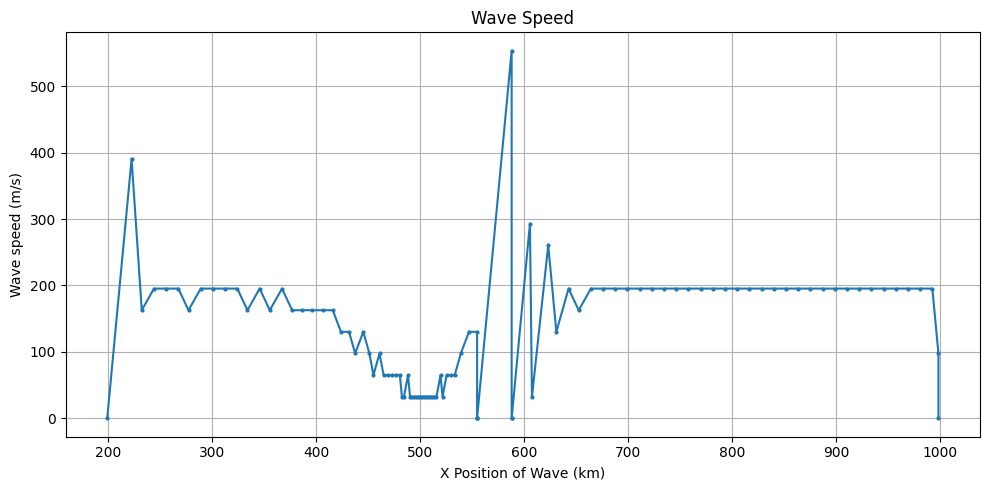

In [8]:
x_pos_of_wave = np.array(x_pos_of_wave)

x_change = np.diff(x_pos_of_wave)
t_change = np.diff(t_save)
speed = x_change / t_change

plt.figure(figsize=(10,5))
plt.plot(np.array(x_pos_of_wave[1:]), speed * Lx / kilometer, '-o', markersize=2)

plt.xlabel("X Position of Wave (km)")
plt.ylabel("Wave speed (m/s)")
plt.title("Wave Speed")

plt.grid(True)
plt.tight_layout()
plt.show()

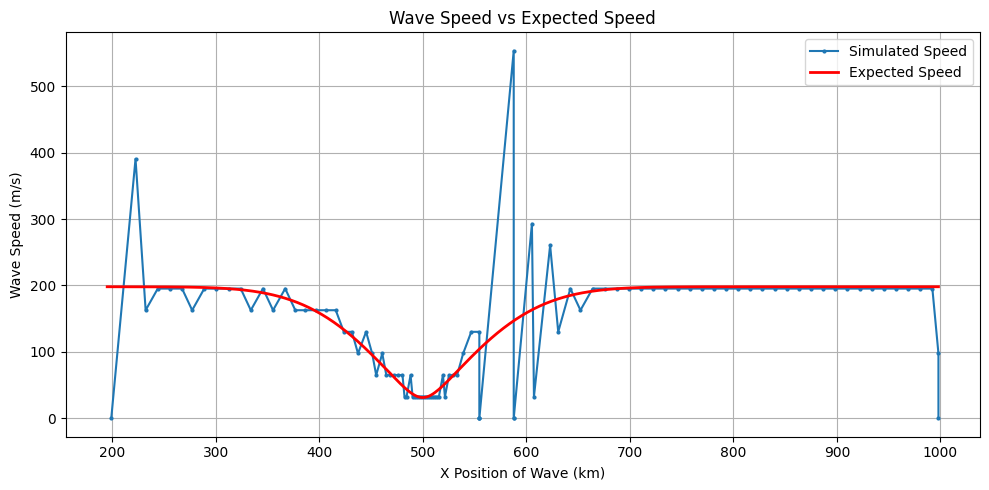

In [9]:

expected_speed = np.sqrt(
    g * (H0 - (H0 - H_min) * np.exp(-(x - x2)**2.0 / w2**2.0))
)

plt.figure(figsize=(10,5))

cutoff = 100

plt.plot(x_pos_of_wave[1:], speed * Lx / kilometer, '-o', markersize=2, label="Simulated Speed")
plt.plot(x[cutoff:] / kilometer, expected_speed[cutoff:], 'r-', linewidth=2, label="Expected Speed")

plt.xlabel("X Position of Wave (km)")
plt.ylabel("Wave Speed (m/s)")
plt.title("Wave Speed vs Expected Speed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The expected speed is a relatively good match for the observed speed, with a few quirks in the data (such as at around 600 meters) due to interference in the waves.

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + \partial_x(u*H) + \partial_y(v*H)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will initilize the Tsunami with the following equation
$$ h=e^{-x^2/w_1^2} $$
$$ u=(g/c)*h $$

where $c=\sqrt{gH_0}$ and $H_0$ is the constant reference depth. The relationship between $u$ and $h$ follows from linearized shallow water equations and corresponds to a wave propagating in the $+x$ direction with a speed $c$.

We will solve the equations in a square domain with periodic boundary conditions and a Gaussian seamount in the middle of the domain with height

$$ H=H_{min}e^{-(x^2+y^2)/w_2^2} $$

The Tsunami should propagate with speed $c$ over the deep ocean where the depth is constant, but the wave will be modified as it passes over the seamount.

### 2.1  Dedalus script to solve the 2D shallow water equations

In [10]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/(w2**2.0))
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 23s, Remaining: 0s, Rate: 4.4e-02/s


2025-11-20 09:46:52,581 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 23s, Remaining: 0s, Rate: 4.4e-02/s


INFO:__main__:Starting main loop


2025-11-20 09:46:52,592 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-20 09:47:07,050 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2025-11-20 09:47:07,054 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2025-11-20 09:47:07,056 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 22.6 sec


2025-11-20 09:47:07,057 solvers 0/1 INFO :: Setup time (init - iter 0): 22.6 sec


INFO:solvers:Warmup time (iter 0-10): 4.811 sec


2025-11-20 09:47:07,058 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.811 sec


INFO:solvers:Run time (iter 10-end): 9.649 sec


2025-11-20 09:47:07,059 solvers 0/1 INFO :: Run time (iter 10-end): 9.649 sec


INFO:solvers:CPU time (iter 10-end): 0.00268 cpu-hr


2025-11-20 09:47:07,060 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00268 cpu-hr


INFO:solvers:Speed: 2.221e+05 mode-stages/cpu-sec


2025-11-20 09:47:07,062 solvers 0/1 INFO :: Speed: 2.221e+05 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

In [94]:
from dedalus.extras import plot_tools

def animate_h(h_save, t_save, title):
  # create a figure and axes
  fig = plt.figure(figsize=(6,6))

  # Create arrays with the x and y coordinates for plotting using pcolor
  (X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

  # Define an animation function
  def drawframe(n):
      plt.clf # clear the figure before plotting the next frame
      height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
      # Specify the axis limits and labels
      plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
      plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
      plt.xlabel('x (km)')
      plt.ylabel('y (m)')
      plt.title('Surface height (m), time = {0:.2f} hours {1}'.format(t_save[n]/(1*hour), title))
      return (height,)

  from matplotlib import animation
  # blit=True re-draws only the parts that have changed.
  anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

  from IPython.display import HTML
  HTML(anim.to_html5_video())

In [ ]:
animate_h(h_save, t_save)

### 2.3 Student investigation
<a id='section2pt3'></a>
Qualitatively describe the influence of the seamount and explain this behavior using the shallow water equations. You can assume that the wave amplitude and velocity are small in the shallow water equations.

The seamount causes the tsunami to slow down. This is because as we saw above, we can derive from the shallow water equations that the speed of the wave is a function of $\sqrt{gH}$, and the seamount means the water is shallower (smaller H), and thus the speed is smaller. However, the parts of the wave farther from the center of the seamount are over relatively deeper water, and so they speed up, leading to the wave to distort with leading edges on the sides away from the seamount, and an indent in front of the seamount.

Try varying some parameters (e.g. the width and height of the wave and/or seamount) and comment on the results. When does the wave no longer obey the linear shallow water equations which are valid for small waves You don't need to do a comprehensive parameter space search, but you should run several simulations with one or two parameters varied.

In [91]:
# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

def get_h_for_time(Lx = 1000 * kilometer, Ly = 1000 * kilometer, Nx = 64, Ny = 64, g = 9.81, H0 = 4 * kilometer, c = np.sqrt(9.81*4*kilometer), H_min = 1 * kilometer, w1 = 50 * kilometer, w2 = 200 * kilometer, x1 = -300 * kilometer):
  timestep = 60 * second # Specify the timestep
  stop_sim_time = 60 * minute # Specify the stopping time

  timestepper = dedalus.RK222
  max_timestep = 0.125

  # Bases
  coords = dedalus.CartesianCoordinates('x', 'y')
  dist = dedalus.Distributor(coords, dtype=np.float64)
  xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
  ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

  x, y = dist.local_grids(xbasis, ybasis)

  # Fields
  u = dist.Field(name='u', bases=(xbasis, ybasis))
  v = dist.Field(name='v', bases=(xbasis, ybasis))
  h = dist.Field(name='h', bases=(xbasis, ybasis))
  H = dist.Field(name='H', bases=(xbasis, ybasis))

  # Initial conditions
  H.change_scales(1)
  h.change_scales(1) # Set values on regular grid
  u.change_scales(1)
  v.change_scales(1)
  H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
  h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
  u['g'] = (g/c)*h['g']
  v['g'] = 0

  # Operators
  dx = lambda a: dedalus.Differentiate(a, coords['x'])
  dy = lambda a: dedalus.Differentiate(a, coords['y'])

  # Problem
  problem = dedalus.IVP([u, v, h], namespace=locals())
  problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
  problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
  problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

  # Solver
  solver = problem.build_solver(dedalus.RK222)
  solver.stop_sim_time = stop_sim_time

  # Analysis
  snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
  snapshots.add_task(h, name='h')
  snapshots.add_task(u, name='u')
  snapshots.add_task(v, name='v')

  h.change_scales(1)
  h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
  # Main loop
  try:
      logger.info('Starting main loop')
      while solver.proceed:
          solver.step(timestep)
          if (solver.iteration-1) % 1 == 0:
              h.change_scales(1)
              h_save.append(np.copy(h['g']))
              t_save.append(solver.sim_time)
  except:
      logger.error('Exception raised, triggering end of main loop.')
      raise
  finally:
      solver.log_stats()

  h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
  return h_save, t_save

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.4e-02/s


2025-11-20 10:44:03,564 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.4e-02/s


INFO:__main__:Starting main loop


2025-11-20 10:44:03,570 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-20 10:44:12,383 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-20 10:44:12,385 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-20 10:44:12,386 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 18.48 sec


2025-11-20 10:44:12,387 solvers 0/1 INFO :: Setup time (init - iter 0): 18.48 sec


INFO:solvers:Warmup time (iter 0-10): 4.312 sec


2025-11-20 10:44:12,388 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.312 sec


INFO:solvers:Run time (iter 10-end): 4.501 sec


2025-11-20 10:44:12,389 solvers 0/1 INFO :: Run time (iter 10-end): 4.501 sec


INFO:solvers:CPU time (iter 10-end): 0.00125 cpu-hr


2025-11-20 10:44:12,391 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00125 cpu-hr


INFO:solvers:Speed: 2.645e+05 mode-stages/cpu-sec


2025-11-20 10:44:12,392 solvers 0/1 INFO :: Speed: 2.645e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-20 10:44:12,507 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpl4_3vih4/temp.m4v


2025-11-20 10:44:12,511 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpl4_3vih4/temp.m4v


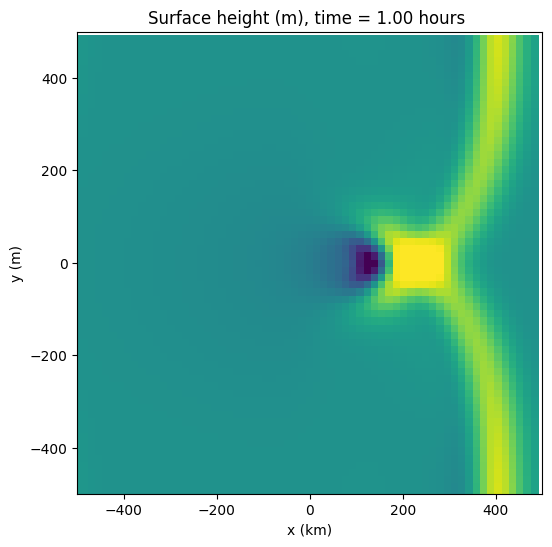

In [95]:
h_save, t_save = get_h_for_time()
animate_h(h_save, t_save, "")

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.5e-02/s


2025-11-20 10:45:57,551 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.5e-02/s


INFO:__main__:Starting main loop


2025-11-20 10:45:57,558 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-20 10:46:06,576 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-20 10:46:06,580 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-20 10:46:06,583 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 18.22 sec


2025-11-20 10:46:06,587 solvers 0/1 INFO :: Setup time (init - iter 0): 18.22 sec


INFO:solvers:Warmup time (iter 0-10): 4.346 sec


2025-11-20 10:46:06,590 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.346 sec


INFO:solvers:Run time (iter 10-end): 4.675 sec


2025-11-20 10:46:06,593 solvers 0/1 INFO :: Run time (iter 10-end): 4.675 sec


INFO:solvers:CPU time (iter 10-end): 0.001299 cpu-hr


2025-11-20 10:46:06,598 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001299 cpu-hr


INFO:solvers:Speed: 2.547e+05 mode-stages/cpu-sec


2025-11-20 10:46:06,601 solvers 0/1 INFO :: Speed: 2.547e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-20 10:46:06,736 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp73fxw_j_/temp.m4v


2025-11-20 10:46:06,738 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp73fxw_j_/temp.m4v


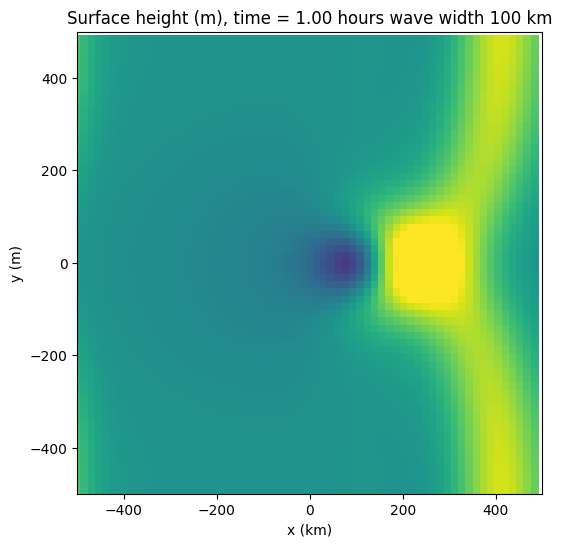

In [96]:
h_save, t_save = get_h_for_time(w1 = 100 * kilometer)
animate_h(h_save, t_save, "wave width 100 km")

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.5e-02/s


2025-11-20 10:47:50,910 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.5e-02/s


INFO:__main__:Starting main loop


2025-11-20 10:47:50,916 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-20 10:47:59,936 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-20 10:47:59,938 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-20 10:47:59,940 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 18.2 sec


2025-11-20 10:47:59,941 solvers 0/1 INFO :: Setup time (init - iter 0): 18.2 sec


INFO:solvers:Warmup time (iter 0-10): 4.389 sec


2025-11-20 10:47:59,944 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.389 sec


INFO:solvers:Run time (iter 10-end): 4.63 sec


2025-11-20 10:47:59,946 solvers 0/1 INFO :: Run time (iter 10-end): 4.63 sec


INFO:solvers:CPU time (iter 10-end): 0.001286 cpu-hr


2025-11-20 10:47:59,948 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001286 cpu-hr


INFO:solvers:Speed: 2.572e+05 mode-stages/cpu-sec


2025-11-20 10:47:59,950 solvers 0/1 INFO :: Speed: 2.572e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-20 10:48:00,102 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpf1dzh9tu/temp.m4v


2025-11-20 10:48:00,104 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpf1dzh9tu/temp.m4v


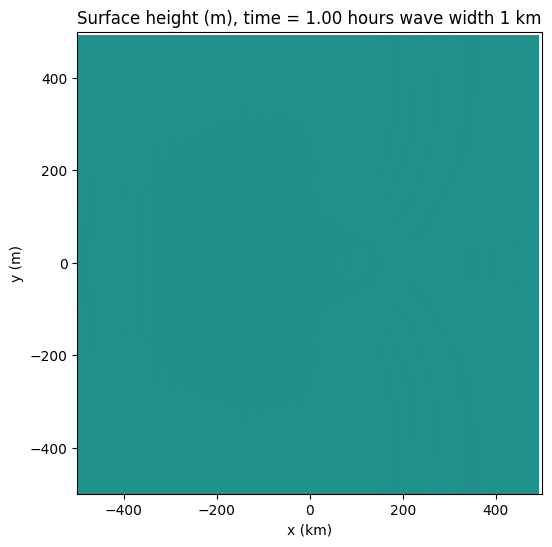

In [97]:
h_save, t_save = get_h_for_time(w1 = 1 * kilometer)
animate_h(h_save, t_save, "wave width 1 km")

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 27s, Remaining: 0s, Rate: 3.7e-02/s


2025-11-20 10:52:56,894 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 27s, Remaining: 0s, Rate: 3.7e-02/s


INFO:__main__:Starting main loop


2025-11-20 10:52:56,899 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-20 10:53:06,500 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-20 10:53:06,502 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-20 10:53:06,503 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 27.21 sec


2025-11-20 10:53:06,507 solvers 0/1 INFO :: Setup time (init - iter 0): 27.21 sec


INFO:solvers:Warmup time (iter 0-10): 4.842 sec


2025-11-20 10:53:06,509 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.842 sec


INFO:solvers:Run time (iter 10-end): 4.759 sec


2025-11-20 10:53:06,511 solvers 0/1 INFO :: Run time (iter 10-end): 4.759 sec


INFO:solvers:CPU time (iter 10-end): 0.001322 cpu-hr


2025-11-20 10:53:06,513 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001322 cpu-hr


INFO:solvers:Speed: 2.502e+05 mode-stages/cpu-sec


2025-11-20 10:53:06,514 solvers 0/1 INFO :: Speed: 2.502e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-20 10:53:06,619 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp6z60l_sg/temp.m4v


2025-11-20 10:53:06,621 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp6z60l_sg/temp.m4v


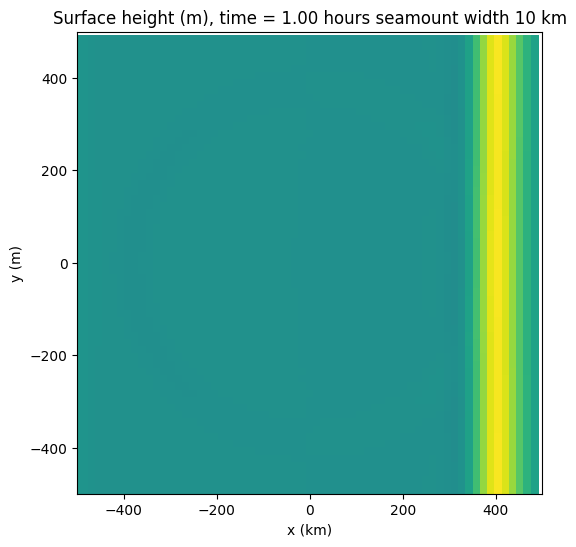

In [103]:
h_save, t_save = get_h_for_time(w2 = 10 * kilometer)
animate_h(h_save, t_save, "seamount width 10 km")

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 31s, Remaining: 0s, Rate: 3.2e-02/s


2025-11-20 10:55:03,745 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 31s, Remaining: 0s, Rate: 3.2e-02/s


INFO:__main__:Starting main loop


2025-11-20 10:55:03,750 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-20 10:55:13,741 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-20 10:55:13,743 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-20 10:55:13,744 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 31.04 sec


2025-11-20 10:55:13,745 solvers 0/1 INFO :: Setup time (init - iter 0): 31.04 sec


INFO:solvers:Warmup time (iter 0-10): 5.226 sec


2025-11-20 10:55:13,747 solvers 0/1 INFO :: Warmup time (iter 0-10): 5.226 sec


INFO:solvers:Run time (iter 10-end): 4.765 sec


2025-11-20 10:55:13,748 solvers 0/1 INFO :: Run time (iter 10-end): 4.765 sec


INFO:solvers:CPU time (iter 10-end): 0.001324 cpu-hr


2025-11-20 10:55:13,750 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001324 cpu-hr


INFO:solvers:Speed: 2.499e+05 mode-stages/cpu-sec


2025-11-20 10:55:13,752 solvers 0/1 INFO :: Speed: 2.499e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-20 10:55:13,858 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpbf382zyg/temp.m4v


2025-11-20 10:55:13,861 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpbf382zyg/temp.m4v


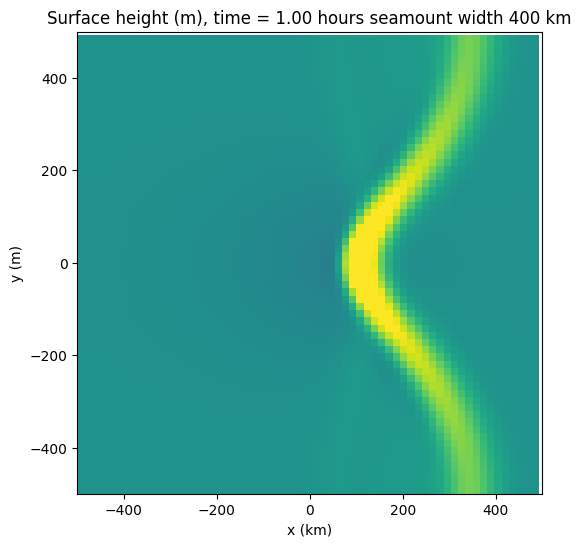

In [104]:
h_save, t_save = get_h_for_time(w2 = 400 * kilometer)
animate_h(h_save, t_save, "seamount width 400 km")

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 27s, Remaining: 0s, Rate: 3.8e-02/s


2025-11-20 10:57:06,779 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 27s, Remaining: 0s, Rate: 3.8e-02/s


INFO:__main__:Starting main loop


2025-11-20 10:57:06,785 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-20 10:57:16,963 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-20 10:57:16,966 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-20 10:57:16,970 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 26.56 sec


2025-11-20 10:57:16,974 solvers 0/1 INFO :: Setup time (init - iter 0): 26.56 sec


INFO:solvers:Warmup time (iter 0-10): 4.263 sec


2025-11-20 10:57:16,975 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.263 sec


INFO:solvers:Run time (iter 10-end): 5.916 sec


2025-11-20 10:57:16,976 solvers 0/1 INFO :: Run time (iter 10-end): 5.916 sec


INFO:solvers:CPU time (iter 10-end): 0.001643 cpu-hr


2025-11-20 10:57:16,978 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001643 cpu-hr


INFO:solvers:Speed: 2.013e+05 mode-stages/cpu-sec


2025-11-20 10:57:16,979 solvers 0/1 INFO :: Speed: 2.013e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-20 10:57:17,083 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpg0khp7_o/temp.m4v


2025-11-20 10:57:17,086 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpg0khp7_o/temp.m4v


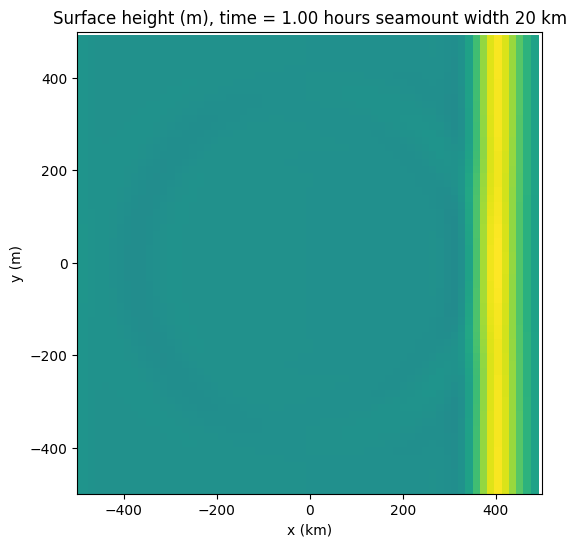

In [105]:
h_save, t_save = get_h_for_time(w2 = 20 * kilometer)
animate_h(h_save, t_save, "seamount width 20 km")

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 10s, Remaining: 0s, Rate: 1.0e-01/s


2025-11-20 11:32:28,615 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 10s, Remaining: 0s, Rate: 1.0e-01/s


INFO:__main__:Starting main loop


2025-11-20 11:32:28,621 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-20 11:32:36,400 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-20 11:32:36,402 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-20 11:32:36,403 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 9.795 sec


2025-11-20 11:32:36,404 solvers 0/1 INFO :: Setup time (init - iter 0): 9.795 sec


INFO:solvers:Warmup time (iter 0-10): 3.722 sec


2025-11-20 11:32:36,406 solvers 0/1 INFO :: Warmup time (iter 0-10): 3.722 sec


INFO:solvers:Run time (iter 10-end): 4.058 sec


2025-11-20 11:32:36,407 solvers 0/1 INFO :: Run time (iter 10-end): 4.058 sec


INFO:solvers:CPU time (iter 10-end): 0.001127 cpu-hr


2025-11-20 11:32:36,408 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001127 cpu-hr


INFO:solvers:Speed: 2.934e+05 mode-stages/cpu-sec


2025-11-20 11:32:36,409 solvers 0/1 INFO :: Speed: 2.934e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-20 11:32:36,534 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpz360uhr0/temp.m4v


2025-11-20 11:32:36,536 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpz360uhr0/temp.m4v


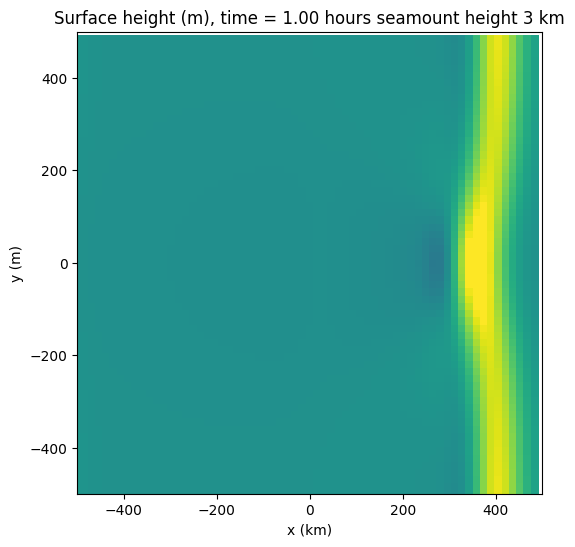

In [125]:
h_save, t_save = get_h_for_time(H_min = 3 * kilometer)
animate_h(h_save, t_save, "seamount height 3 km")

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 20s, Remaining: 0s, Rate: 4.9e-02/s


2025-11-20 11:30:42,771 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 20s, Remaining: 0s, Rate: 4.9e-02/s


INFO:__main__:Starting main loop


2025-11-20 11:30:42,776 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-20 11:30:52,503 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-20 11:30:52,505 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-20 11:30:52,506 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 20.3 sec


2025-11-20 11:30:52,508 solvers 0/1 INFO :: Setup time (init - iter 0): 20.3 sec


INFO:solvers:Warmup time (iter 0-10): 5.087 sec


2025-11-20 11:30:52,509 solvers 0/1 INFO :: Warmup time (iter 0-10): 5.087 sec


INFO:solvers:Run time (iter 10-end): 4.641 sec


2025-11-20 11:30:52,510 solvers 0/1 INFO :: Run time (iter 10-end): 4.641 sec


INFO:solvers:CPU time (iter 10-end): 0.001289 cpu-hr


2025-11-20 11:30:52,511 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001289 cpu-hr


INFO:solvers:Speed: 2.566e+05 mode-stages/cpu-sec


2025-11-20 11:30:52,512 solvers 0/1 INFO :: Speed: 2.566e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-20 11:30:52,625 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpswzfgrk0/temp.m4v


2025-11-20 11:30:52,629 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpswzfgrk0/temp.m4v


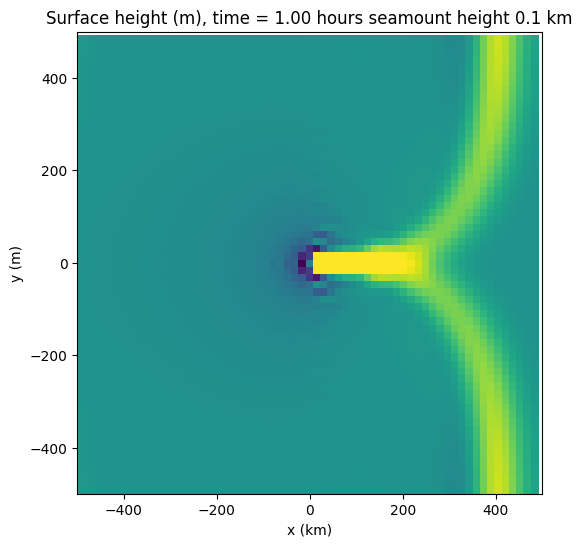

In [124]:
h_save, t_save = get_h_for_time(H_min = 0.1 * kilometer)
animate_h(h_save, t_save, "seamount height 0.1 km")

Above I've varied the width of the wave, and the width of the seamount. We can see the seamount has a greater impact on the wave when the width of the wave is increased, but the simulation breaks when the width of the wave is too small.

As the wavemount's width is shrunk to very small, it, as expected, has little effect on the final shape of the wave, and when it is large, the final shape of wave is proportional to the shape of the seamount.

I've also varied the height of the seamount. Predictably, when the seamount is not very tall, it has little impact on the trajectory of the wave. However, when the top seamount is very close to the surface, the portion of the wave passing over the seamount moves very slowly and reaches a large height over a course of a couple hundred kilometers. Under these conditions, the assumption that H >> h is no longer true, and the wave is likely no longer obeying our shallow water equations for small waves.

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way. In this part of the project, we will assume that the bottom of the ocean is flat and that the resting height of the ocean is a constant $H$.  

We will use Dedalus to solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [11]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

# changed for higher resolution
timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 5 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.7e+01/s


2025-11-20 09:47:07,990 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.7e+01/s


2025-11-20 09:47:08,113 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.7e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.9e+01/s


2025-11-20 09:47:08,249 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.9e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 4.9e+01/s


2025-11-20 09:47:08,393 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 4.9e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 4.9e+01/s


2025-11-20 09:47:08,532 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 4.9e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.0e+01/s


2025-11-20 09:47:08,669 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.0e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.0e+01/s


2025-11-20 09:47:08,804 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.0e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.0e+01/s


2025-11-20 09:47:08,944 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.0e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 4.9e+01/s


2025-11-20 09:47:09,105 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 4.9e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.9e+01/s


2025-11-20 09:47:09,248 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.9e+01/s


INFO:__main__:Starting main loop


2025-11-20 09:47:09,253 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2025-11-20 09:47:12,611 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=6, Time=3.600000e+03, dt=6.000000e+02


2025-11-20 09:47:13,222 __main__ 0/1 INFO :: Iteration=6, Time=3.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2025-11-20 09:47:13,557 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=16, Time=9.600000e+03, dt=6.000000e+02


2025-11-20 09:47:13,885 __main__ 0/1 INFO :: Iteration=16, Time=9.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2025-11-20 09:47:14,230 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=26, Time=1.560000e+04, dt=6.000000e+02


2025-11-20 09:47:14,566 __main__ 0/1 INFO :: Iteration=26, Time=1.560000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2025-11-20 09:47:14,893 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=36, Time=2.160000e+04, dt=6.000000e+02


2025-11-20 09:47:15,231 __main__ 0/1 INFO :: Iteration=36, Time=2.160000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2025-11-20 09:47:15,589 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=46, Time=2.760000e+04, dt=6.000000e+02


2025-11-20 09:47:15,912 __main__ 0/1 INFO :: Iteration=46, Time=2.760000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2025-11-20 09:47:16,241 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=56, Time=3.360000e+04, dt=6.000000e+02


2025-11-20 09:47:16,592 __main__ 0/1 INFO :: Iteration=56, Time=3.360000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2025-11-20 09:47:17,072 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=66, Time=3.960000e+04, dt=6.000000e+02


2025-11-20 09:47:17,643 __main__ 0/1 INFO :: Iteration=66, Time=3.960000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2025-11-20 09:47:18,206 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=76, Time=4.560000e+04, dt=6.000000e+02


2025-11-20 09:47:18,842 __main__ 0/1 INFO :: Iteration=76, Time=4.560000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2025-11-20 09:47:19,512 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=86, Time=5.160000e+04, dt=6.000000e+02


2025-11-20 09:47:20,004 __main__ 0/1 INFO :: Iteration=86, Time=5.160000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2025-11-20 09:47:20,554 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=96, Time=5.760000e+04, dt=6.000000e+02


2025-11-20 09:47:20,916 __main__ 0/1 INFO :: Iteration=96, Time=5.760000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2025-11-20 09:47:21,255 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=106, Time=6.360000e+04, dt=6.000000e+02


2025-11-20 09:47:21,585 __main__ 0/1 INFO :: Iteration=106, Time=6.360000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2025-11-20 09:47:21,948 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=116, Time=6.960000e+04, dt=6.000000e+02


2025-11-20 09:47:22,283 __main__ 0/1 INFO :: Iteration=116, Time=6.960000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2025-11-20 09:47:22,614 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=126, Time=7.560000e+04, dt=6.000000e+02


2025-11-20 09:47:22,956 __main__ 0/1 INFO :: Iteration=126, Time=7.560000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2025-11-20 09:47:23,294 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=136, Time=8.160000e+04, dt=6.000000e+02


2025-11-20 09:47:23,630 __main__ 0/1 INFO :: Iteration=136, Time=8.160000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2025-11-20 09:47:23,974 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=146, Time=8.760000e+04, dt=6.000000e+02


2025-11-20 09:47:24,313 __main__ 0/1 INFO :: Iteration=146, Time=8.760000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2025-11-20 09:47:24,669 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=156, Time=9.360000e+04, dt=6.000000e+02


2025-11-20 09:47:25,015 __main__ 0/1 INFO :: Iteration=156, Time=9.360000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2025-11-20 09:47:25,356 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=166, Time=9.960000e+04, dt=6.000000e+02


2025-11-20 09:47:25,689 __main__ 0/1 INFO :: Iteration=166, Time=9.960000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2025-11-20 09:47:26,036 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=176, Time=1.056000e+05, dt=6.000000e+02


2025-11-20 09:47:26,377 __main__ 0/1 INFO :: Iteration=176, Time=1.056000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2025-11-20 09:47:26,710 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=186, Time=1.116000e+05, dt=6.000000e+02


2025-11-20 09:47:27,052 __main__ 0/1 INFO :: Iteration=186, Time=1.116000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2025-11-20 09:47:27,403 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=196, Time=1.176000e+05, dt=6.000000e+02


2025-11-20 09:47:27,741 __main__ 0/1 INFO :: Iteration=196, Time=1.176000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2025-11-20 09:47:28,095 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=206, Time=1.236000e+05, dt=6.000000e+02


2025-11-20 09:47:28,447 __main__ 0/1 INFO :: Iteration=206, Time=1.236000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2025-11-20 09:47:28,776 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=216, Time=1.296000e+05, dt=6.000000e+02


2025-11-20 09:47:29,109 __main__ 0/1 INFO :: Iteration=216, Time=1.296000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2025-11-20 09:47:29,466 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=226, Time=1.356000e+05, dt=6.000000e+02


2025-11-20 09:47:29,794 __main__ 0/1 INFO :: Iteration=226, Time=1.356000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2025-11-20 09:47:30,135 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=236, Time=1.416000e+05, dt=6.000000e+02


2025-11-20 09:47:30,485 __main__ 0/1 INFO :: Iteration=236, Time=1.416000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2025-11-20 09:47:31,081 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=246, Time=1.476000e+05, dt=6.000000e+02


2025-11-20 09:47:31,738 __main__ 0/1 INFO :: Iteration=246, Time=1.476000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2025-11-20 09:47:32,371 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=256, Time=1.536000e+05, dt=6.000000e+02


2025-11-20 09:47:32,859 __main__ 0/1 INFO :: Iteration=256, Time=1.536000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2025-11-20 09:47:33,457 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=266, Time=1.596000e+05, dt=6.000000e+02


2025-11-20 09:47:34,022 __main__ 0/1 INFO :: Iteration=266, Time=1.596000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2025-11-20 09:47:34,494 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=276, Time=1.656000e+05, dt=6.000000e+02


2025-11-20 09:47:34,855 __main__ 0/1 INFO :: Iteration=276, Time=1.656000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2025-11-20 09:47:35,449 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=286, Time=1.716000e+05, dt=6.000000e+02


2025-11-20 09:47:35,823 __main__ 0/1 INFO :: Iteration=286, Time=1.716000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2025-11-20 09:47:36,171 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=296, Time=1.776000e+05, dt=6.000000e+02


2025-11-20 09:47:36,519 __main__ 0/1 INFO :: Iteration=296, Time=1.776000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2025-11-20 09:47:36,870 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=306, Time=1.836000e+05, dt=6.000000e+02


2025-11-20 09:47:37,197 __main__ 0/1 INFO :: Iteration=306, Time=1.836000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2025-11-20 09:47:37,540 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=316, Time=1.896000e+05, dt=6.000000e+02


2025-11-20 09:47:37,887 __main__ 0/1 INFO :: Iteration=316, Time=1.896000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2025-11-20 09:47:38,226 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=326, Time=1.956000e+05, dt=6.000000e+02


2025-11-20 09:47:38,568 __main__ 0/1 INFO :: Iteration=326, Time=1.956000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2025-11-20 09:47:38,919 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=336, Time=2.016000e+05, dt=6.000000e+02


2025-11-20 09:47:39,253 __main__ 0/1 INFO :: Iteration=336, Time=2.016000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2025-11-20 09:47:39,590 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=346, Time=2.076000e+05, dt=6.000000e+02


2025-11-20 09:47:39,931 __main__ 0/1 INFO :: Iteration=346, Time=2.076000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2025-11-20 09:47:40,298 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=356, Time=2.136000e+05, dt=6.000000e+02


2025-11-20 09:47:40,635 __main__ 0/1 INFO :: Iteration=356, Time=2.136000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2025-11-20 09:47:40,978 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=366, Time=2.196000e+05, dt=6.000000e+02


2025-11-20 09:47:41,347 __main__ 0/1 INFO :: Iteration=366, Time=2.196000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2025-11-20 09:47:41,685 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=376, Time=2.256000e+05, dt=6.000000e+02


2025-11-20 09:47:42,015 __main__ 0/1 INFO :: Iteration=376, Time=2.256000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2025-11-20 09:47:42,377 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=386, Time=2.316000e+05, dt=6.000000e+02


2025-11-20 09:47:42,724 __main__ 0/1 INFO :: Iteration=386, Time=2.316000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2025-11-20 09:47:43,070 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=396, Time=2.376000e+05, dt=6.000000e+02


2025-11-20 09:47:43,421 __main__ 0/1 INFO :: Iteration=396, Time=2.376000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2025-11-20 09:47:43,784 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=406, Time=2.436000e+05, dt=6.000000e+02


2025-11-20 09:47:44,223 __main__ 0/1 INFO :: Iteration=406, Time=2.436000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2025-11-20 09:47:45,816 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=416, Time=2.496000e+05, dt=6.000000e+02


2025-11-20 09:47:47,041 __main__ 0/1 INFO :: Iteration=416, Time=2.496000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2025-11-20 09:47:48,266 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=426, Time=2.556000e+05, dt=6.000000e+02


2025-11-20 09:47:48,647 __main__ 0/1 INFO :: Iteration=426, Time=2.556000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2025-11-20 09:47:49,186 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=436, Time=2.616000e+05, dt=6.000000e+02


2025-11-20 09:47:49,839 __main__ 0/1 INFO :: Iteration=436, Time=2.616000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2025-11-20 09:47:50,188 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=446, Time=2.676000e+05, dt=6.000000e+02


2025-11-20 09:47:50,849 __main__ 0/1 INFO :: Iteration=446, Time=2.676000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2025-11-20 09:47:51,675 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=456, Time=2.736000e+05, dt=6.000000e+02


2025-11-20 09:47:52,387 __main__ 0/1 INFO :: Iteration=456, Time=2.736000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2025-11-20 09:47:53,229 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=466, Time=2.796000e+05, dt=6.000000e+02


2025-11-20 09:47:54,000 __main__ 0/1 INFO :: Iteration=466, Time=2.796000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2025-11-20 09:47:54,637 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=476, Time=2.856000e+05, dt=6.000000e+02


2025-11-20 09:47:55,046 __main__ 0/1 INFO :: Iteration=476, Time=2.856000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2025-11-20 09:47:55,376 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=486, Time=2.916000e+05, dt=6.000000e+02


2025-11-20 09:47:55,712 __main__ 0/1 INFO :: Iteration=486, Time=2.916000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2025-11-20 09:47:56,063 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=496, Time=2.976000e+05, dt=6.000000e+02


2025-11-20 09:47:56,392 __main__ 0/1 INFO :: Iteration=496, Time=2.976000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2025-11-20 09:47:56,735 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=506, Time=3.036000e+05, dt=6.000000e+02


2025-11-20 09:47:57,095 __main__ 0/1 INFO :: Iteration=506, Time=3.036000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2025-11-20 09:47:57,443 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=516, Time=3.096000e+05, dt=6.000000e+02


2025-11-20 09:47:57,919 __main__ 0/1 INFO :: Iteration=516, Time=3.096000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2025-11-20 09:47:58,413 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=526, Time=3.156000e+05, dt=6.000000e+02


2025-11-20 09:47:59,079 __main__ 0/1 INFO :: Iteration=526, Time=3.156000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2025-11-20 09:47:59,873 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=536, Time=3.216000e+05, dt=6.000000e+02


2025-11-20 09:48:00,472 __main__ 0/1 INFO :: Iteration=536, Time=3.216000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2025-11-20 09:48:01,042 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=546, Time=3.276000e+05, dt=6.000000e+02


2025-11-20 09:48:01,503 __main__ 0/1 INFO :: Iteration=546, Time=3.276000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2025-11-20 09:48:01,845 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=556, Time=3.336000e+05, dt=6.000000e+02


2025-11-20 09:48:02,180 __main__ 0/1 INFO :: Iteration=556, Time=3.336000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2025-11-20 09:48:02,548 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=566, Time=3.396000e+05, dt=6.000000e+02


2025-11-20 09:48:02,889 __main__ 0/1 INFO :: Iteration=566, Time=3.396000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2025-11-20 09:48:03,225 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=576, Time=3.456000e+05, dt=6.000000e+02


2025-11-20 09:48:03,584 __main__ 0/1 INFO :: Iteration=576, Time=3.456000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2025-11-20 09:48:03,924 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=586, Time=3.516000e+05, dt=6.000000e+02


2025-11-20 09:48:04,273 __main__ 0/1 INFO :: Iteration=586, Time=3.516000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2025-11-20 09:48:04,645 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=596, Time=3.576000e+05, dt=6.000000e+02


2025-11-20 09:48:04,995 __main__ 0/1 INFO :: Iteration=596, Time=3.576000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2025-11-20 09:48:05,359 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=606, Time=3.636000e+05, dt=6.000000e+02


2025-11-20 09:48:05,713 __main__ 0/1 INFO :: Iteration=606, Time=3.636000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2025-11-20 09:48:06,070 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=616, Time=3.696000e+05, dt=6.000000e+02


2025-11-20 09:48:06,410 __main__ 0/1 INFO :: Iteration=616, Time=3.696000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2025-11-20 09:48:06,773 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=626, Time=3.756000e+05, dt=6.000000e+02


2025-11-20 09:48:07,096 __main__ 0/1 INFO :: Iteration=626, Time=3.756000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2025-11-20 09:48:07,431 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=636, Time=3.816000e+05, dt=6.000000e+02


2025-11-20 09:48:07,797 __main__ 0/1 INFO :: Iteration=636, Time=3.816000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2025-11-20 09:48:08,120 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=646, Time=3.876000e+05, dt=6.000000e+02


2025-11-20 09:48:08,472 __main__ 0/1 INFO :: Iteration=646, Time=3.876000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2025-11-20 09:48:08,814 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=656, Time=3.936000e+05, dt=6.000000e+02


2025-11-20 09:48:09,150 __main__ 0/1 INFO :: Iteration=656, Time=3.936000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2025-11-20 09:48:09,486 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=666, Time=3.996000e+05, dt=6.000000e+02


2025-11-20 09:48:09,839 __main__ 0/1 INFO :: Iteration=666, Time=3.996000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2025-11-20 09:48:10,174 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=676, Time=4.056000e+05, dt=6.000000e+02


2025-11-20 09:48:10,514 __main__ 0/1 INFO :: Iteration=676, Time=4.056000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2025-11-20 09:48:10,856 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=686, Time=4.116000e+05, dt=6.000000e+02


2025-11-20 09:48:11,211 __main__ 0/1 INFO :: Iteration=686, Time=4.116000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2025-11-20 09:48:11,634 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=696, Time=4.176000e+05, dt=6.000000e+02


2025-11-20 09:48:12,212 __main__ 0/1 INFO :: Iteration=696, Time=4.176000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2025-11-20 09:48:12,963 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=706, Time=4.236000e+05, dt=6.000000e+02


2025-11-20 09:48:13,508 __main__ 0/1 INFO :: Iteration=706, Time=4.236000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2025-11-20 09:48:14,036 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=716, Time=4.296000e+05, dt=6.000000e+02


2025-11-20 09:48:14,648 __main__ 0/1 INFO :: Iteration=716, Time=4.296000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2025-11-20 09:48:15,267 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=726, Time=4.356000e+05, dt=6.000000e+02


2025-11-20 09:48:15,598 __main__ 0/1 INFO :: Iteration=726, Time=4.356000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2025-11-20 09:48:15,935 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=736, Time=4.416000e+05, dt=6.000000e+02


2025-11-20 09:48:16,288 __main__ 0/1 INFO :: Iteration=736, Time=4.416000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2025-11-20 09:48:16,626 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=746, Time=4.476000e+05, dt=6.000000e+02


2025-11-20 09:48:16,959 __main__ 0/1 INFO :: Iteration=746, Time=4.476000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2025-11-20 09:48:17,293 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=756, Time=4.536000e+05, dt=6.000000e+02


2025-11-20 09:48:17,630 __main__ 0/1 INFO :: Iteration=756, Time=4.536000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2025-11-20 09:48:17,965 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=766, Time=4.596000e+05, dt=6.000000e+02


2025-11-20 09:48:18,296 __main__ 0/1 INFO :: Iteration=766, Time=4.596000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2025-11-20 09:48:18,631 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=776, Time=4.656000e+05, dt=6.000000e+02


2025-11-20 09:48:18,961 __main__ 0/1 INFO :: Iteration=776, Time=4.656000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2025-11-20 09:48:19,294 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=786, Time=4.716000e+05, dt=6.000000e+02


2025-11-20 09:48:19,630 __main__ 0/1 INFO :: Iteration=786, Time=4.716000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2025-11-20 09:48:19,960 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=796, Time=4.776000e+05, dt=6.000000e+02


2025-11-20 09:48:20,307 __main__ 0/1 INFO :: Iteration=796, Time=4.776000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2025-11-20 09:48:20,675 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=806, Time=4.836000e+05, dt=6.000000e+02


2025-11-20 09:48:21,010 __main__ 0/1 INFO :: Iteration=806, Time=4.836000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2025-11-20 09:48:21,344 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=816, Time=4.896000e+05, dt=6.000000e+02


2025-11-20 09:48:21,690 __main__ 0/1 INFO :: Iteration=816, Time=4.896000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2025-11-20 09:48:22,022 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=826, Time=4.956000e+05, dt=6.000000e+02


2025-11-20 09:48:22,352 __main__ 0/1 INFO :: Iteration=826, Time=4.956000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2025-11-20 09:48:22,707 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=836, Time=5.016000e+05, dt=6.000000e+02


2025-11-20 09:48:23,072 __main__ 0/1 INFO :: Iteration=836, Time=5.016000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2025-11-20 09:48:23,406 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=846, Time=5.076000e+05, dt=6.000000e+02


2025-11-20 09:48:23,765 __main__ 0/1 INFO :: Iteration=846, Time=5.076000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2025-11-20 09:48:24,106 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=856, Time=5.136000e+05, dt=6.000000e+02


2025-11-20 09:48:24,455 __main__ 0/1 INFO :: Iteration=856, Time=5.136000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2025-11-20 09:48:24,854 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=866, Time=5.196000e+05, dt=6.000000e+02


2025-11-20 09:48:25,211 __main__ 0/1 INFO :: Iteration=866, Time=5.196000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2025-11-20 09:48:25,661 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=876, Time=5.256000e+05, dt=6.000000e+02


2025-11-20 09:48:26,321 __main__ 0/1 INFO :: Iteration=876, Time=5.256000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2025-11-20 09:48:27,017 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=886, Time=5.316000e+05, dt=6.000000e+02


2025-11-20 09:48:27,755 __main__ 0/1 INFO :: Iteration=886, Time=5.316000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2025-11-20 09:48:28,412 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=896, Time=5.376000e+05, dt=6.000000e+02


2025-11-20 09:48:28,994 __main__ 0/1 INFO :: Iteration=896, Time=5.376000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2025-11-20 09:48:29,353 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=906, Time=5.436000e+05, dt=6.000000e+02


2025-11-20 09:48:29,680 __main__ 0/1 INFO :: Iteration=906, Time=5.436000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2025-11-20 09:48:30,020 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=916, Time=5.496000e+05, dt=6.000000e+02


2025-11-20 09:48:30,382 __main__ 0/1 INFO :: Iteration=916, Time=5.496000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2025-11-20 09:48:30,715 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=926, Time=5.556000e+05, dt=6.000000e+02


2025-11-20 09:48:31,067 __main__ 0/1 INFO :: Iteration=926, Time=5.556000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2025-11-20 09:48:31,413 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=936, Time=5.616000e+05, dt=6.000000e+02


2025-11-20 09:48:31,744 __main__ 0/1 INFO :: Iteration=936, Time=5.616000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2025-11-20 09:48:32,080 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=946, Time=5.676000e+05, dt=6.000000e+02


2025-11-20 09:48:32,426 __main__ 0/1 INFO :: Iteration=946, Time=5.676000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2025-11-20 09:48:32,755 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=956, Time=5.736000e+05, dt=6.000000e+02


2025-11-20 09:48:33,087 __main__ 0/1 INFO :: Iteration=956, Time=5.736000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2025-11-20 09:48:33,426 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=966, Time=5.796000e+05, dt=6.000000e+02


2025-11-20 09:48:33,751 __main__ 0/1 INFO :: Iteration=966, Time=5.796000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2025-11-20 09:48:34,091 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=976, Time=5.856000e+05, dt=6.000000e+02


2025-11-20 09:48:34,455 __main__ 0/1 INFO :: Iteration=976, Time=5.856000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2025-11-20 09:48:34,790 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=986, Time=5.916000e+05, dt=6.000000e+02


2025-11-20 09:48:35,201 __main__ 0/1 INFO :: Iteration=986, Time=5.916000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2025-11-20 09:48:36,122 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=996, Time=5.976000e+05, dt=6.000000e+02


2025-11-20 09:48:36,723 __main__ 0/1 INFO :: Iteration=996, Time=5.976000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2025-11-20 09:48:37,116 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1006, Time=6.036000e+05, dt=6.000000e+02


2025-11-20 09:48:37,458 __main__ 0/1 INFO :: Iteration=1006, Time=6.036000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2025-11-20 09:48:37,852 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1016, Time=6.096000e+05, dt=6.000000e+02


2025-11-20 09:48:38,199 __main__ 0/1 INFO :: Iteration=1016, Time=6.096000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2025-11-20 09:48:38,549 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1026, Time=6.156000e+05, dt=6.000000e+02


2025-11-20 09:48:38,915 __main__ 0/1 INFO :: Iteration=1026, Time=6.156000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2025-11-20 09:48:39,566 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1036, Time=6.216000e+05, dt=6.000000e+02


2025-11-20 09:48:40,354 __main__ 0/1 INFO :: Iteration=1036, Time=6.216000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2025-11-20 09:48:41,016 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1046, Time=6.276000e+05, dt=6.000000e+02


2025-11-20 09:48:41,656 __main__ 0/1 INFO :: Iteration=1046, Time=6.276000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2025-11-20 09:48:42,279 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1056, Time=6.336000e+05, dt=6.000000e+02


2025-11-20 09:48:42,771 __main__ 0/1 INFO :: Iteration=1056, Time=6.336000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2025-11-20 09:48:43,131 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1066, Time=6.396000e+05, dt=6.000000e+02


2025-11-20 09:48:43,480 __main__ 0/1 INFO :: Iteration=1066, Time=6.396000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2025-11-20 09:48:43,822 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1076, Time=6.456000e+05, dt=6.000000e+02


2025-11-20 09:48:44,175 __main__ 0/1 INFO :: Iteration=1076, Time=6.456000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2025-11-20 09:48:44,530 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1086, Time=6.516000e+05, dt=6.000000e+02


2025-11-20 09:48:44,871 __main__ 0/1 INFO :: Iteration=1086, Time=6.516000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2025-11-20 09:48:45,224 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1096, Time=6.576000e+05, dt=6.000000e+02


2025-11-20 09:48:45,560 __main__ 0/1 INFO :: Iteration=1096, Time=6.576000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2025-11-20 09:48:45,898 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1106, Time=6.636000e+05, dt=6.000000e+02


2025-11-20 09:48:46,257 __main__ 0/1 INFO :: Iteration=1106, Time=6.636000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2025-11-20 09:48:46,594 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1116, Time=6.696000e+05, dt=6.000000e+02


2025-11-20 09:48:46,981 __main__ 0/1 INFO :: Iteration=1116, Time=6.696000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2025-11-20 09:48:47,422 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1126, Time=6.756000e+05, dt=6.000000e+02


2025-11-20 09:48:47,879 __main__ 0/1 INFO :: Iteration=1126, Time=6.756000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2025-11-20 09:48:48,303 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1136, Time=6.816000e+05, dt=6.000000e+02


2025-11-20 09:48:48,702 __main__ 0/1 INFO :: Iteration=1136, Time=6.816000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2025-11-20 09:48:49,053 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1146, Time=6.876000e+05, dt=6.000000e+02


2025-11-20 09:48:49,409 __main__ 0/1 INFO :: Iteration=1146, Time=6.876000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2025-11-20 09:48:49,744 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1156, Time=6.936000e+05, dt=6.000000e+02


2025-11-20 09:48:50,114 __main__ 0/1 INFO :: Iteration=1156, Time=6.936000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2025-11-20 09:48:50,462 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1166, Time=6.996000e+05, dt=6.000000e+02


2025-11-20 09:48:50,808 __main__ 0/1 INFO :: Iteration=1166, Time=6.996000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2025-11-20 09:48:51,244 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1176, Time=7.056000e+05, dt=6.000000e+02


2025-11-20 09:48:51,598 __main__ 0/1 INFO :: Iteration=1176, Time=7.056000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2025-11-20 09:48:52,058 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1186, Time=7.116000e+05, dt=6.000000e+02


2025-11-20 09:48:52,385 __main__ 0/1 INFO :: Iteration=1186, Time=7.116000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2025-11-20 09:48:53,310 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1196, Time=7.176000e+05, dt=6.000000e+02


2025-11-20 09:48:54,298 __main__ 0/1 INFO :: Iteration=1196, Time=7.176000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2025-11-20 09:48:55,106 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1206, Time=7.236000e+05, dt=6.000000e+02


2025-11-20 09:48:55,773 __main__ 0/1 INFO :: Iteration=1206, Time=7.236000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2025-11-20 09:48:56,405 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1216, Time=7.296000e+05, dt=6.000000e+02


2025-11-20 09:48:56,947 __main__ 0/1 INFO :: Iteration=1216, Time=7.296000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2025-11-20 09:48:57,304 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1226, Time=7.356000e+05, dt=6.000000e+02


2025-11-20 09:48:57,653 __main__ 0/1 INFO :: Iteration=1226, Time=7.356000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2025-11-20 09:48:58,189 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1236, Time=7.416000e+05, dt=6.000000e+02


2025-11-20 09:48:58,528 __main__ 0/1 INFO :: Iteration=1236, Time=7.416000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2025-11-20 09:48:58,869 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1246, Time=7.476000e+05, dt=6.000000e+02


2025-11-20 09:48:59,217 __main__ 0/1 INFO :: Iteration=1246, Time=7.476000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2025-11-20 09:48:59,755 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1256, Time=7.536000e+05, dt=6.000000e+02


2025-11-20 09:49:00,598 __main__ 0/1 INFO :: Iteration=1256, Time=7.536000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2025-11-20 09:49:01,574 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1266, Time=7.596000e+05, dt=6.000000e+02


2025-11-20 09:49:02,322 __main__ 0/1 INFO :: Iteration=1266, Time=7.596000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2025-11-20 09:49:02,688 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1276, Time=7.656000e+05, dt=6.000000e+02


2025-11-20 09:49:03,239 __main__ 0/1 INFO :: Iteration=1276, Time=7.656000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2025-11-20 09:49:03,946 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1286, Time=7.716000e+05, dt=6.000000e+02


2025-11-20 09:49:04,740 __main__ 0/1 INFO :: Iteration=1286, Time=7.716000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2025-11-20 09:49:05,215 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1296, Time=7.776000e+05, dt=6.000000e+02


2025-11-20 09:49:05,676 __main__ 0/1 INFO :: Iteration=1296, Time=7.776000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2025-11-20 09:49:06,031 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1306, Time=7.836000e+05, dt=6.000000e+02


2025-11-20 09:49:06,482 __main__ 0/1 INFO :: Iteration=1306, Time=7.836000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2025-11-20 09:49:06,930 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1316, Time=7.896000e+05, dt=6.000000e+02


2025-11-20 09:49:07,713 __main__ 0/1 INFO :: Iteration=1316, Time=7.896000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2025-11-20 09:49:08,501 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1326, Time=7.956000e+05, dt=6.000000e+02


2025-11-20 09:49:09,052 __main__ 0/1 INFO :: Iteration=1326, Time=7.956000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2025-11-20 09:49:09,564 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1336, Time=8.016000e+05, dt=6.000000e+02


2025-11-20 09:49:10,145 __main__ 0/1 INFO :: Iteration=1336, Time=8.016000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2025-11-20 09:49:10,495 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1346, Time=8.076000e+05, dt=6.000000e+02


2025-11-20 09:49:10,846 __main__ 0/1 INFO :: Iteration=1346, Time=8.076000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2025-11-20 09:49:11,192 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1356, Time=8.136000e+05, dt=6.000000e+02


2025-11-20 09:49:11,545 __main__ 0/1 INFO :: Iteration=1356, Time=8.136000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2025-11-20 09:49:11,882 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1366, Time=8.196000e+05, dt=6.000000e+02


2025-11-20 09:49:12,227 __main__ 0/1 INFO :: Iteration=1366, Time=8.196000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2025-11-20 09:49:12,571 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1376, Time=8.256000e+05, dt=6.000000e+02


2025-11-20 09:49:12,899 __main__ 0/1 INFO :: Iteration=1376, Time=8.256000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2025-11-20 09:49:13,255 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1386, Time=8.316000e+05, dt=6.000000e+02


2025-11-20 09:49:13,586 __main__ 0/1 INFO :: Iteration=1386, Time=8.316000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2025-11-20 09:49:13,916 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1396, Time=8.376000e+05, dt=6.000000e+02


2025-11-20 09:49:14,274 __main__ 0/1 INFO :: Iteration=1396, Time=8.376000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2025-11-20 09:49:14,626 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1406, Time=8.436000e+05, dt=6.000000e+02


2025-11-20 09:49:14,964 __main__ 0/1 INFO :: Iteration=1406, Time=8.436000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2025-11-20 09:49:15,313 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1416, Time=8.496000e+05, dt=6.000000e+02


2025-11-20 09:49:15,651 __main__ 0/1 INFO :: Iteration=1416, Time=8.496000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2025-11-20 09:49:15,997 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1426, Time=8.556000e+05, dt=6.000000e+02


2025-11-20 09:49:16,385 __main__ 0/1 INFO :: Iteration=1426, Time=8.556000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2025-11-20 09:49:16,746 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1436, Time=8.616000e+05, dt=6.000000e+02


2025-11-20 09:49:17,105 __main__ 0/1 INFO :: Iteration=1436, Time=8.616000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2025-11-20 09:49:17,415 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2025-11-20 09:49:17,418 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2025-11-20 09:49:17,419 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 1.347 sec


2025-11-20 09:49:17,423 solvers 0/1 INFO :: Setup time (init - iter 0): 1.347 sec


INFO:solvers:Warmup time (iter 0-10): 4.237 sec


2025-11-20 09:49:17,427 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.237 sec


INFO:solvers:Run time (iter 10-end): 123.9 sec


2025-11-20 09:49:17,431 solvers 0/1 INFO :: Run time (iter 10-end): 123.9 sec


INFO:solvers:CPU time (iter 10-end): 0.03442 cpu-hr


2025-11-20 09:49:17,434 solvers 0/1 INFO :: CPU time (iter 10-end): 0.03442 cpu-hr


INFO:solvers:Speed: 2.79e+05 mode-stages/cpu-sec


2025-11-20 09:49:17,437 solvers 0/1 INFO :: Speed: 2.79e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. You should modifty the code to save the height more often so that you can clearly see the shape of the wave. Notice that as the waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

32 48


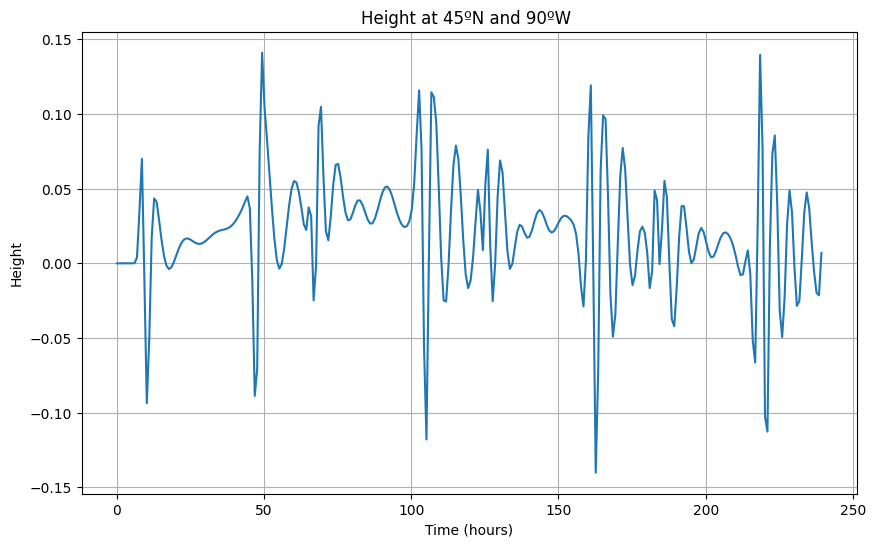

In [12]:
# Reminder to self
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)

print(int(90/360*Nphi), int((90+45)/180*Ntheta))
heights = []
for timeslice in h_save:
  heights.append(timeslice[int(90/360*Nphi)][int((90+45)/180*Ntheta)])

plt.figure(figsize=(10, 6))
plt.plot(np.array(t_save) / hour, heights)

plt.xlabel('Time (hours)')
plt.ylabel('Height')
plt.title(f'Height at 45ºN and 90ºW ')
plt.grid(True)
plt.show()


We can see a clear repeating pattering every 50 hours or so, with a few variations between each iteration. There's a few natural causes that can cause the variability in the waves at different times. The first is interference - the waves will travel around the planet many times, and interact with each other and themselves, leading to some differences on each revolution. Another is the coriolis force; the earth is constantly rotating and the waves are experiencing a force that will deflect them as time increases.  

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves from the theoretical dispersion relation and compare this estimate with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [109]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt
import math

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

# changed for higher resolution
timestep = 600 * second
stop_sim_time = 30 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)
damping = dist.Field(name='damping', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

damping = dist.Field(name='damping', bases=basis)
damping['g'] =  ((1/2 * (1+np.tanh((phi - 3*np.pi/2)/(np.pi/10))) + 1/2 * (1-np.tanh((phi - np.pi/2)/(np.pi/10)))))

# Problem
problem = dedalus.IVP([u, h], namespace=locals())

problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) - 1/(0.1 * day) * h * damping")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.2e+01/s


2025-11-20 11:06:50,870 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.2e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 6.9e+01/s


2025-11-20 11:06:50,948 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 6.9e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 7.4e+01/s


2025-11-20 11:06:51,037 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 7.4e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 7.2e+01/s


2025-11-20 11:06:51,139 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 7.2e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


2025-11-20 11:06:51,233 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


2025-11-20 11:06:51,323 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 7.4e+01/s


2025-11-20 11:06:51,416 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 7.4e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 7.3e+01/s


2025-11-20 11:06:51,518 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 7.3e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 7.3e+01/s


2025-11-20 11:06:51,611 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 7.3e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.4e+01/s


2025-11-20 11:06:51,702 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.4e+01/s


INFO:__main__:Starting main loop


2025-11-20 11:06:51,712 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2025-11-20 11:06:54,988 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2025-11-20 11:06:56,071 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2025-11-20 11:06:56,879 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2025-11-20 11:06:57,695 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2025-11-20 11:06:58,530 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2025-11-20 11:06:59,356 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2025-11-20 11:07:00,173 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2025-11-20 11:07:01,705 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2025-11-20 11:07:03,165 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2025-11-20 11:07:04,152 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2025-11-20 11:07:04,978 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2025-11-20 11:07:05,834 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2025-11-20 11:07:06,681 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2025-11-20 11:07:07,516 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2025-11-20 11:07:08,328 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2025-11-20 11:07:09,155 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2025-11-20 11:07:09,988 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2025-11-20 11:07:10,810 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2025-11-20 11:07:11,623 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2025-11-20 11:07:12,458 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2025-11-20 11:07:13,292 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2025-11-20 11:07:14,373 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2025-11-20 11:07:15,862 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2025-11-20 11:07:17,116 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2025-11-20 11:07:17,940 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2025-11-20 11:07:18,774 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2025-11-20 11:07:19,608 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2025-11-20 11:07:20,477 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2025-11-20 11:07:21,271 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2025-11-20 11:07:22,089 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2025-11-20 11:07:22,926 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2025-11-20 11:07:23,737 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2025-11-20 11:07:24,564 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2025-11-20 11:07:25,380 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2025-11-20 11:07:26,202 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2025-11-20 11:07:27,040 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2025-11-20 11:07:28,452 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2025-11-20 11:07:29,840 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2025-11-20 11:07:30,985 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2025-11-20 11:07:31,784 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2025-11-20 11:07:32,623 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2025-11-20 11:07:33,454 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2025-11-20 11:07:34,311 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2025-11-20 11:07:35,108 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2025-11-20 11:07:35,924 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2025-11-20 11:07:36,733 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2025-11-20 11:07:37,579 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2025-11-20 11:07:38,400 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2025-11-20 11:07:39,188 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2025-11-20 11:07:40,014 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2025-11-20 11:07:40,970 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2025-11-20 11:07:42,445 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2025-11-20 11:07:43,884 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2025-11-20 11:07:44,800 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2025-11-20 11:07:45,603 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2025-11-20 11:07:46,443 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2025-11-20 11:07:47,286 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2025-11-20 11:07:48,122 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2025-11-20 11:07:48,943 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2025-11-20 11:07:49,754 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2025-11-20 11:07:50,632 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2025-11-20 11:07:51,449 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2025-11-20 11:07:52,269 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2025-11-20 11:07:53,102 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2025-11-20 11:07:53,923 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2025-11-20 11:07:55,187 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2025-11-20 11:07:56,525 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2025-11-20 11:07:57,838 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2025-11-20 11:07:58,690 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2025-11-20 11:07:59,526 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2025-11-20 11:08:00,370 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2025-11-20 11:08:01,194 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2025-11-20 11:08:02,012 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2025-11-20 11:08:02,814 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2025-11-20 11:08:03,631 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2025-11-20 11:08:04,448 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2025-11-20 11:08:05,278 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2025-11-20 11:08:06,084 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2025-11-20 11:08:06,905 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2025-11-20 11:08:07,734 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2025-11-20 11:08:09,163 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2025-11-20 11:08:10,664 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2025-11-20 11:08:11,697 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2025-11-20 11:08:12,512 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2025-11-20 11:08:13,343 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2025-11-20 11:08:14,165 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2025-11-20 11:08:15,003 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2025-11-20 11:08:15,822 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2025-11-20 11:08:16,617 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2025-11-20 11:08:17,437 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2025-11-20 11:08:18,271 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2025-11-20 11:08:19,117 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2025-11-20 11:08:19,995 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2025-11-20 11:08:20,812 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2025-11-20 11:08:21,886 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2025-11-20 11:08:23,444 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2025-11-20 11:08:24,690 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2025-11-20 11:08:25,516 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2025-11-20 11:08:26,336 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2025-11-20 11:08:27,161 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2025-11-20 11:08:28,025 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2025-11-20 11:08:28,868 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2025-11-20 11:08:29,695 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2025-11-20 11:08:30,517 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2025-11-20 11:08:31,326 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2025-11-20 11:08:32,160 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2025-11-20 11:08:32,986 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2025-11-20 11:08:33,787 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2025-11-20 11:08:34,595 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2025-11-20 11:08:35,988 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2025-11-20 11:08:37,522 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2025-11-20 11:08:38,563 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2025-11-20 11:08:39,394 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2025-11-20 11:08:40,202 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2025-11-20 11:08:41,029 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2025-11-20 11:08:41,836 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2025-11-20 11:08:42,702 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2025-11-20 11:08:43,533 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2025-11-20 11:08:44,374 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2025-11-20 11:08:45,196 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2025-11-20 11:08:46,056 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2025-11-20 11:08:46,873 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2025-11-20 11:08:47,688 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2025-11-20 11:08:48,920 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2025-11-20 11:08:50,584 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2025-11-20 11:08:51,680 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2025-11-20 11:08:52,522 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2025-11-20 11:08:53,344 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2025-11-20 11:08:54,153 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2025-11-20 11:08:54,979 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2025-11-20 11:08:55,811 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2025-11-20 11:08:56,657 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2025-11-20 11:08:57,512 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2025-11-20 11:08:58,326 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2025-11-20 11:08:59,150 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2025-11-20 11:08:59,974 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2025-11-20 11:09:00,800 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2025-11-20 11:09:01,829 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2025-11-20 11:09:03,409 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2025-11-20 11:09:04,769 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2025-11-20 11:09:05,591 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2025-11-20 11:09:06,434 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2025-11-20 11:09:07,264 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2025-11-20 11:09:08,078 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1441, Time=8.646000e+05, dt=6.000000e+02


2025-11-20 11:09:08,911 __main__ 0/1 INFO :: Iteration=1441, Time=8.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1451, Time=8.706000e+05, dt=6.000000e+02


2025-11-20 11:09:09,751 __main__ 0/1 INFO :: Iteration=1451, Time=8.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1461, Time=8.766000e+05, dt=6.000000e+02


2025-11-20 11:09:10,568 __main__ 0/1 INFO :: Iteration=1461, Time=8.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1471, Time=8.826000e+05, dt=6.000000e+02


2025-11-20 11:09:11,400 __main__ 0/1 INFO :: Iteration=1471, Time=8.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1481, Time=8.886000e+05, dt=6.000000e+02


2025-11-20 11:09:12,195 __main__ 0/1 INFO :: Iteration=1481, Time=8.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1491, Time=8.946000e+05, dt=6.000000e+02


2025-11-20 11:09:13,016 __main__ 0/1 INFO :: Iteration=1491, Time=8.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1501, Time=9.006000e+05, dt=6.000000e+02


2025-11-20 11:09:13,860 __main__ 0/1 INFO :: Iteration=1501, Time=9.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1511, Time=9.066000e+05, dt=6.000000e+02


2025-11-20 11:09:14,676 __main__ 0/1 INFO :: Iteration=1511, Time=9.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1521, Time=9.126000e+05, dt=6.000000e+02


2025-11-20 11:09:15,912 __main__ 0/1 INFO :: Iteration=1521, Time=9.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1531, Time=9.186000e+05, dt=6.000000e+02


2025-11-20 11:09:17,536 __main__ 0/1 INFO :: Iteration=1531, Time=9.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1541, Time=9.246000e+05, dt=6.000000e+02


2025-11-20 11:09:18,664 __main__ 0/1 INFO :: Iteration=1541, Time=9.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1551, Time=9.306000e+05, dt=6.000000e+02


2025-11-20 11:09:19,482 __main__ 0/1 INFO :: Iteration=1551, Time=9.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1561, Time=9.366000e+05, dt=6.000000e+02


2025-11-20 11:09:20,335 __main__ 0/1 INFO :: Iteration=1561, Time=9.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1571, Time=9.426000e+05, dt=6.000000e+02


2025-11-20 11:09:21,169 __main__ 0/1 INFO :: Iteration=1571, Time=9.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1581, Time=9.486000e+05, dt=6.000000e+02


2025-11-20 11:09:22,008 __main__ 0/1 INFO :: Iteration=1581, Time=9.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1591, Time=9.546000e+05, dt=6.000000e+02


2025-11-20 11:09:22,810 __main__ 0/1 INFO :: Iteration=1591, Time=9.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1601, Time=9.606000e+05, dt=6.000000e+02


2025-11-20 11:09:23,659 __main__ 0/1 INFO :: Iteration=1601, Time=9.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1611, Time=9.666000e+05, dt=6.000000e+02


2025-11-20 11:09:24,480 __main__ 0/1 INFO :: Iteration=1611, Time=9.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1621, Time=9.726000e+05, dt=6.000000e+02


2025-11-20 11:09:25,307 __main__ 0/1 INFO :: Iteration=1621, Time=9.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1631, Time=9.786000e+05, dt=6.000000e+02


2025-11-20 11:09:26,102 __main__ 0/1 INFO :: Iteration=1631, Time=9.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1641, Time=9.846000e+05, dt=6.000000e+02


2025-11-20 11:09:26,938 __main__ 0/1 INFO :: Iteration=1641, Time=9.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1651, Time=9.906000e+05, dt=6.000000e+02


2025-11-20 11:09:27,763 __main__ 0/1 INFO :: Iteration=1651, Time=9.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1661, Time=9.966000e+05, dt=6.000000e+02


2025-11-20 11:09:28,698 __main__ 0/1 INFO :: Iteration=1661, Time=9.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1671, Time=1.002600e+06, dt=6.000000e+02


2025-11-20 11:09:30,098 __main__ 0/1 INFO :: Iteration=1671, Time=1.002600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1681, Time=1.008600e+06, dt=6.000000e+02


2025-11-20 11:09:31,522 __main__ 0/1 INFO :: Iteration=1681, Time=1.008600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1691, Time=1.014600e+06, dt=6.000000e+02


2025-11-20 11:09:32,505 __main__ 0/1 INFO :: Iteration=1691, Time=1.014600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1701, Time=1.020600e+06, dt=6.000000e+02


2025-11-20 11:09:33,368 __main__ 0/1 INFO :: Iteration=1701, Time=1.020600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1711, Time=1.026600e+06, dt=6.000000e+02


2025-11-20 11:09:34,192 __main__ 0/1 INFO :: Iteration=1711, Time=1.026600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1721, Time=1.032600e+06, dt=6.000000e+02


2025-11-20 11:09:35,018 __main__ 0/1 INFO :: Iteration=1721, Time=1.032600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1731, Time=1.038600e+06, dt=6.000000e+02


2025-11-20 11:09:35,844 __main__ 0/1 INFO :: Iteration=1731, Time=1.038600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1741, Time=1.044600e+06, dt=6.000000e+02


2025-11-20 11:09:36,651 __main__ 0/1 INFO :: Iteration=1741, Time=1.044600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1751, Time=1.050600e+06, dt=6.000000e+02


2025-11-20 11:09:37,473 __main__ 0/1 INFO :: Iteration=1751, Time=1.050600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1761, Time=1.056600e+06, dt=6.000000e+02


2025-11-20 11:09:38,284 __main__ 0/1 INFO :: Iteration=1761, Time=1.056600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1771, Time=1.062600e+06, dt=6.000000e+02


2025-11-20 11:09:39,088 __main__ 0/1 INFO :: Iteration=1771, Time=1.062600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1781, Time=1.068600e+06, dt=6.000000e+02


2025-11-20 11:09:39,894 __main__ 0/1 INFO :: Iteration=1781, Time=1.068600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1791, Time=1.074600e+06, dt=6.000000e+02


2025-11-20 11:09:40,716 __main__ 0/1 INFO :: Iteration=1791, Time=1.074600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1801, Time=1.080600e+06, dt=6.000000e+02


2025-11-20 11:09:41,572 __main__ 0/1 INFO :: Iteration=1801, Time=1.080600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1811, Time=1.086600e+06, dt=6.000000e+02


2025-11-20 11:09:42,643 __main__ 0/1 INFO :: Iteration=1811, Time=1.086600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1821, Time=1.092600e+06, dt=6.000000e+02


2025-11-20 11:09:44,127 __main__ 0/1 INFO :: Iteration=1821, Time=1.092600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1831, Time=1.098600e+06, dt=6.000000e+02


2025-11-20 11:09:45,400 __main__ 0/1 INFO :: Iteration=1831, Time=1.098600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1841, Time=1.104600e+06, dt=6.000000e+02


2025-11-20 11:09:46,250 __main__ 0/1 INFO :: Iteration=1841, Time=1.104600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1851, Time=1.110600e+06, dt=6.000000e+02


2025-11-20 11:09:47,113 __main__ 0/1 INFO :: Iteration=1851, Time=1.110600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1861, Time=1.116600e+06, dt=6.000000e+02


2025-11-20 11:09:47,946 __main__ 0/1 INFO :: Iteration=1861, Time=1.116600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1871, Time=1.122600e+06, dt=6.000000e+02


2025-11-20 11:09:48,789 __main__ 0/1 INFO :: Iteration=1871, Time=1.122600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1881, Time=1.128600e+06, dt=6.000000e+02


2025-11-20 11:09:49,599 __main__ 0/1 INFO :: Iteration=1881, Time=1.128600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1891, Time=1.134600e+06, dt=6.000000e+02


2025-11-20 11:09:50,455 __main__ 0/1 INFO :: Iteration=1891, Time=1.134600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1901, Time=1.140600e+06, dt=6.000000e+02


2025-11-20 11:09:51,288 __main__ 0/1 INFO :: Iteration=1901, Time=1.140600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1911, Time=1.146600e+06, dt=6.000000e+02


2025-11-20 11:09:52,109 __main__ 0/1 INFO :: Iteration=1911, Time=1.146600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1921, Time=1.152600e+06, dt=6.000000e+02


2025-11-20 11:09:52,954 __main__ 0/1 INFO :: Iteration=1921, Time=1.152600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1931, Time=1.158600e+06, dt=6.000000e+02


2025-11-20 11:09:53,759 __main__ 0/1 INFO :: Iteration=1931, Time=1.158600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1941, Time=1.164600e+06, dt=6.000000e+02


2025-11-20 11:09:54,612 __main__ 0/1 INFO :: Iteration=1941, Time=1.164600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1951, Time=1.170600e+06, dt=6.000000e+02


2025-11-20 11:09:55,479 __main__ 0/1 INFO :: Iteration=1951, Time=1.170600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1961, Time=1.176600e+06, dt=6.000000e+02


2025-11-20 11:09:57,042 __main__ 0/1 INFO :: Iteration=1961, Time=1.176600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1971, Time=1.182600e+06, dt=6.000000e+02


2025-11-20 11:09:58,334 __main__ 0/1 INFO :: Iteration=1971, Time=1.182600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1981, Time=1.188600e+06, dt=6.000000e+02


2025-11-20 11:09:59,329 __main__ 0/1 INFO :: Iteration=1981, Time=1.188600e+06, dt=6.000000e+02


INFO:__main__:Iteration=1991, Time=1.194600e+06, dt=6.000000e+02


2025-11-20 11:10:00,157 __main__ 0/1 INFO :: Iteration=1991, Time=1.194600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2001, Time=1.200600e+06, dt=6.000000e+02


2025-11-20 11:10:00,998 __main__ 0/1 INFO :: Iteration=2001, Time=1.200600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2011, Time=1.206600e+06, dt=6.000000e+02


2025-11-20 11:10:01,836 __main__ 0/1 INFO :: Iteration=2011, Time=1.206600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2021, Time=1.212600e+06, dt=6.000000e+02


2025-11-20 11:10:02,667 __main__ 0/1 INFO :: Iteration=2021, Time=1.212600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2031, Time=1.218600e+06, dt=6.000000e+02


2025-11-20 11:10:03,465 __main__ 0/1 INFO :: Iteration=2031, Time=1.218600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2041, Time=1.224600e+06, dt=6.000000e+02


2025-11-20 11:10:04,294 __main__ 0/1 INFO :: Iteration=2041, Time=1.224600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2051, Time=1.230600e+06, dt=6.000000e+02


2025-11-20 11:10:05,121 __main__ 0/1 INFO :: Iteration=2051, Time=1.230600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2061, Time=1.236600e+06, dt=6.000000e+02


2025-11-20 11:10:05,970 __main__ 0/1 INFO :: Iteration=2061, Time=1.236600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2071, Time=1.242600e+06, dt=6.000000e+02


2025-11-20 11:10:06,773 __main__ 0/1 INFO :: Iteration=2071, Time=1.242600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2081, Time=1.248600e+06, dt=6.000000e+02


2025-11-20 11:10:07,610 __main__ 0/1 INFO :: Iteration=2081, Time=1.248600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2091, Time=1.254600e+06, dt=6.000000e+02


2025-11-20 11:10:08,430 __main__ 0/1 INFO :: Iteration=2091, Time=1.254600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2101, Time=1.260600e+06, dt=6.000000e+02


2025-11-20 11:10:09,448 __main__ 0/1 INFO :: Iteration=2101, Time=1.260600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2111, Time=1.266600e+06, dt=6.000000e+02


2025-11-20 11:10:11,136 __main__ 0/1 INFO :: Iteration=2111, Time=1.266600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2121, Time=1.272600e+06, dt=6.000000e+02


2025-11-20 11:10:12,463 __main__ 0/1 INFO :: Iteration=2121, Time=1.272600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2131, Time=1.278600e+06, dt=6.000000e+02


2025-11-20 11:10:13,294 __main__ 0/1 INFO :: Iteration=2131, Time=1.278600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2141, Time=1.284600e+06, dt=6.000000e+02


2025-11-20 11:10:14,096 __main__ 0/1 INFO :: Iteration=2141, Time=1.284600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2151, Time=1.290600e+06, dt=6.000000e+02


2025-11-20 11:10:14,921 __main__ 0/1 INFO :: Iteration=2151, Time=1.290600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2161, Time=1.296600e+06, dt=6.000000e+02


2025-11-20 11:10:15,733 __main__ 0/1 INFO :: Iteration=2161, Time=1.296600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2171, Time=1.302600e+06, dt=6.000000e+02


2025-11-20 11:10:16,548 __main__ 0/1 INFO :: Iteration=2171, Time=1.302600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2181, Time=1.308600e+06, dt=6.000000e+02


2025-11-20 11:10:17,344 __main__ 0/1 INFO :: Iteration=2181, Time=1.308600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2191, Time=1.314600e+06, dt=6.000000e+02


2025-11-20 11:10:18,182 __main__ 0/1 INFO :: Iteration=2191, Time=1.314600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2201, Time=1.320600e+06, dt=6.000000e+02


2025-11-20 11:10:19,032 __main__ 0/1 INFO :: Iteration=2201, Time=1.320600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2211, Time=1.326600e+06, dt=6.000000e+02


2025-11-20 11:10:19,843 __main__ 0/1 INFO :: Iteration=2211, Time=1.326600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2221, Time=1.332600e+06, dt=6.000000e+02


2025-11-20 11:10:20,666 __main__ 0/1 INFO :: Iteration=2221, Time=1.332600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2231, Time=1.338600e+06, dt=6.000000e+02


2025-11-20 11:10:21,490 __main__ 0/1 INFO :: Iteration=2231, Time=1.338600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2241, Time=1.344600e+06, dt=6.000000e+02


2025-11-20 11:10:22,330 __main__ 0/1 INFO :: Iteration=2241, Time=1.344600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2251, Time=1.350600e+06, dt=6.000000e+02


2025-11-20 11:10:23,791 __main__ 0/1 INFO :: Iteration=2251, Time=1.350600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2261, Time=1.356600e+06, dt=6.000000e+02


2025-11-20 11:10:25,220 __main__ 0/1 INFO :: Iteration=2261, Time=1.356600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2271, Time=1.362600e+06, dt=6.000000e+02


2025-11-20 11:10:26,292 __main__ 0/1 INFO :: Iteration=2271, Time=1.362600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2281, Time=1.368600e+06, dt=6.000000e+02


2025-11-20 11:10:27,122 __main__ 0/1 INFO :: Iteration=2281, Time=1.368600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2291, Time=1.374600e+06, dt=6.000000e+02


2025-11-20 11:10:27,973 __main__ 0/1 INFO :: Iteration=2291, Time=1.374600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2301, Time=1.380600e+06, dt=6.000000e+02


2025-11-20 11:10:28,809 __main__ 0/1 INFO :: Iteration=2301, Time=1.380600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2311, Time=1.386600e+06, dt=6.000000e+02


2025-11-20 11:10:29,627 __main__ 0/1 INFO :: Iteration=2311, Time=1.386600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2321, Time=1.392600e+06, dt=6.000000e+02


2025-11-20 11:10:30,442 __main__ 0/1 INFO :: Iteration=2321, Time=1.392600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2331, Time=1.398600e+06, dt=6.000000e+02


2025-11-20 11:10:31,254 __main__ 0/1 INFO :: Iteration=2331, Time=1.398600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2341, Time=1.404600e+06, dt=6.000000e+02


2025-11-20 11:10:32,089 __main__ 0/1 INFO :: Iteration=2341, Time=1.404600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2351, Time=1.410600e+06, dt=6.000000e+02


2025-11-20 11:10:32,911 __main__ 0/1 INFO :: Iteration=2351, Time=1.410600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2361, Time=1.416600e+06, dt=6.000000e+02


2025-11-20 11:10:33,745 __main__ 0/1 INFO :: Iteration=2361, Time=1.416600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2371, Time=1.422600e+06, dt=6.000000e+02


2025-11-20 11:10:34,553 __main__ 0/1 INFO :: Iteration=2371, Time=1.422600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2381, Time=1.428600e+06, dt=6.000000e+02


2025-11-20 11:10:35,366 __main__ 0/1 INFO :: Iteration=2381, Time=1.428600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2391, Time=1.434600e+06, dt=6.000000e+02


2025-11-20 11:10:36,454 __main__ 0/1 INFO :: Iteration=2391, Time=1.434600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2401, Time=1.440600e+06, dt=6.000000e+02


2025-11-20 11:10:38,026 __main__ 0/1 INFO :: Iteration=2401, Time=1.440600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2411, Time=1.446600e+06, dt=6.000000e+02


2025-11-20 11:10:39,244 __main__ 0/1 INFO :: Iteration=2411, Time=1.446600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2421, Time=1.452600e+06, dt=6.000000e+02


2025-11-20 11:10:40,078 __main__ 0/1 INFO :: Iteration=2421, Time=1.452600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2431, Time=1.458600e+06, dt=6.000000e+02


2025-11-20 11:10:40,887 __main__ 0/1 INFO :: Iteration=2431, Time=1.458600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2441, Time=1.464600e+06, dt=6.000000e+02


2025-11-20 11:10:41,735 __main__ 0/1 INFO :: Iteration=2441, Time=1.464600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2451, Time=1.470600e+06, dt=6.000000e+02


2025-11-20 11:10:42,586 __main__ 0/1 INFO :: Iteration=2451, Time=1.470600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2461, Time=1.476600e+06, dt=6.000000e+02


2025-11-20 11:10:43,428 __main__ 0/1 INFO :: Iteration=2461, Time=1.476600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2471, Time=1.482600e+06, dt=6.000000e+02


2025-11-20 11:10:44,233 __main__ 0/1 INFO :: Iteration=2471, Time=1.482600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2481, Time=1.488600e+06, dt=6.000000e+02


2025-11-20 11:10:45,061 __main__ 0/1 INFO :: Iteration=2481, Time=1.488600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2491, Time=1.494600e+06, dt=6.000000e+02


2025-11-20 11:10:45,878 __main__ 0/1 INFO :: Iteration=2491, Time=1.494600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2501, Time=1.500600e+06, dt=6.000000e+02


2025-11-20 11:10:46,715 __main__ 0/1 INFO :: Iteration=2501, Time=1.500600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2511, Time=1.506600e+06, dt=6.000000e+02


2025-11-20 11:10:47,574 __main__ 0/1 INFO :: Iteration=2511, Time=1.506600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2521, Time=1.512600e+06, dt=6.000000e+02


2025-11-20 11:10:48,374 __main__ 0/1 INFO :: Iteration=2521, Time=1.512600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2531, Time=1.518600e+06, dt=6.000000e+02


2025-11-20 11:10:49,186 __main__ 0/1 INFO :: Iteration=2531, Time=1.518600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2541, Time=1.524600e+06, dt=6.000000e+02


2025-11-20 11:10:50,526 __main__ 0/1 INFO :: Iteration=2541, Time=1.524600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2551, Time=1.530600e+06, dt=6.000000e+02


2025-11-20 11:10:52,186 __main__ 0/1 INFO :: Iteration=2551, Time=1.530600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2561, Time=1.536600e+06, dt=6.000000e+02


2025-11-20 11:10:53,279 __main__ 0/1 INFO :: Iteration=2561, Time=1.536600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2571, Time=1.542600e+06, dt=6.000000e+02


2025-11-20 11:10:54,113 __main__ 0/1 INFO :: Iteration=2571, Time=1.542600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2581, Time=1.548600e+06, dt=6.000000e+02


2025-11-20 11:10:54,931 __main__ 0/1 INFO :: Iteration=2581, Time=1.548600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2591, Time=1.554600e+06, dt=6.000000e+02


2025-11-20 11:10:55,765 __main__ 0/1 INFO :: Iteration=2591, Time=1.554600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2601, Time=1.560600e+06, dt=6.000000e+02


2025-11-20 11:10:56,602 __main__ 0/1 INFO :: Iteration=2601, Time=1.560600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2611, Time=1.566600e+06, dt=6.000000e+02


2025-11-20 11:10:57,446 __main__ 0/1 INFO :: Iteration=2611, Time=1.566600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2621, Time=1.572600e+06, dt=6.000000e+02


2025-11-20 11:10:58,301 __main__ 0/1 INFO :: Iteration=2621, Time=1.572600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2631, Time=1.578600e+06, dt=6.000000e+02


2025-11-20 11:10:59,130 __main__ 0/1 INFO :: Iteration=2631, Time=1.578600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2641, Time=1.584600e+06, dt=6.000000e+02


2025-11-20 11:10:59,974 __main__ 0/1 INFO :: Iteration=2641, Time=1.584600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2651, Time=1.590600e+06, dt=6.000000e+02


2025-11-20 11:11:00,812 __main__ 0/1 INFO :: Iteration=2651, Time=1.590600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2661, Time=1.596600e+06, dt=6.000000e+02


2025-11-20 11:11:01,667 __main__ 0/1 INFO :: Iteration=2661, Time=1.596600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2671, Time=1.602600e+06, dt=6.000000e+02


2025-11-20 11:11:02,516 __main__ 0/1 INFO :: Iteration=2671, Time=1.602600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2681, Time=1.608600e+06, dt=6.000000e+02


2025-11-20 11:11:03,765 __main__ 0/1 INFO :: Iteration=2681, Time=1.608600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2691, Time=1.614600e+06, dt=6.000000e+02


2025-11-20 11:11:05,246 __main__ 0/1 INFO :: Iteration=2691, Time=1.614600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2701, Time=1.620600e+06, dt=6.000000e+02


2025-11-20 11:11:06,460 __main__ 0/1 INFO :: Iteration=2701, Time=1.620600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2711, Time=1.626600e+06, dt=6.000000e+02


2025-11-20 11:11:07,292 __main__ 0/1 INFO :: Iteration=2711, Time=1.626600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2721, Time=1.632600e+06, dt=6.000000e+02


2025-11-20 11:11:08,119 __main__ 0/1 INFO :: Iteration=2721, Time=1.632600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2731, Time=1.638600e+06, dt=6.000000e+02


2025-11-20 11:11:08,938 __main__ 0/1 INFO :: Iteration=2731, Time=1.638600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2741, Time=1.644600e+06, dt=6.000000e+02


2025-11-20 11:11:09,749 __main__ 0/1 INFO :: Iteration=2741, Time=1.644600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2751, Time=1.650600e+06, dt=6.000000e+02


2025-11-20 11:11:10,580 __main__ 0/1 INFO :: Iteration=2751, Time=1.650600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2761, Time=1.656600e+06, dt=6.000000e+02


2025-11-20 11:11:11,404 __main__ 0/1 INFO :: Iteration=2761, Time=1.656600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2771, Time=1.662600e+06, dt=6.000000e+02


2025-11-20 11:11:12,242 __main__ 0/1 INFO :: Iteration=2771, Time=1.662600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2781, Time=1.668600e+06, dt=6.000000e+02


2025-11-20 11:11:13,069 __main__ 0/1 INFO :: Iteration=2781, Time=1.668600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2791, Time=1.674600e+06, dt=6.000000e+02


2025-11-20 11:11:13,897 __main__ 0/1 INFO :: Iteration=2791, Time=1.674600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2801, Time=1.680600e+06, dt=6.000000e+02


2025-11-20 11:11:14,739 __main__ 0/1 INFO :: Iteration=2801, Time=1.680600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2811, Time=1.686600e+06, dt=6.000000e+02


2025-11-20 11:11:15,565 __main__ 0/1 INFO :: Iteration=2811, Time=1.686600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2821, Time=1.692600e+06, dt=6.000000e+02


2025-11-20 11:11:16,482 __main__ 0/1 INFO :: Iteration=2821, Time=1.692600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2831, Time=1.698600e+06, dt=6.000000e+02


2025-11-20 11:11:17,652 __main__ 0/1 INFO :: Iteration=2831, Time=1.698600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2841, Time=1.704600e+06, dt=6.000000e+02


2025-11-20 11:11:18,963 __main__ 0/1 INFO :: Iteration=2841, Time=1.704600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2851, Time=1.710600e+06, dt=6.000000e+02


2025-11-20 11:11:20,261 __main__ 0/1 INFO :: Iteration=2851, Time=1.710600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2861, Time=1.716600e+06, dt=6.000000e+02


2025-11-20 11:11:21,117 __main__ 0/1 INFO :: Iteration=2861, Time=1.716600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2871, Time=1.722600e+06, dt=6.000000e+02


2025-11-20 11:11:21,946 __main__ 0/1 INFO :: Iteration=2871, Time=1.722600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2881, Time=1.728600e+06, dt=6.000000e+02


2025-11-20 11:11:22,758 __main__ 0/1 INFO :: Iteration=2881, Time=1.728600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2891, Time=1.734600e+06, dt=6.000000e+02


2025-11-20 11:11:23,586 __main__ 0/1 INFO :: Iteration=2891, Time=1.734600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2901, Time=1.740600e+06, dt=6.000000e+02


2025-11-20 11:11:24,445 __main__ 0/1 INFO :: Iteration=2901, Time=1.740600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2911, Time=1.746600e+06, dt=6.000000e+02


2025-11-20 11:11:25,295 __main__ 0/1 INFO :: Iteration=2911, Time=1.746600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2921, Time=1.752600e+06, dt=6.000000e+02


2025-11-20 11:11:26,133 __main__ 0/1 INFO :: Iteration=2921, Time=1.752600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2931, Time=1.758600e+06, dt=6.000000e+02


2025-11-20 11:11:26,947 __main__ 0/1 INFO :: Iteration=2931, Time=1.758600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2941, Time=1.764600e+06, dt=6.000000e+02


2025-11-20 11:11:27,773 __main__ 0/1 INFO :: Iteration=2941, Time=1.764600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2951, Time=1.770600e+06, dt=6.000000e+02


2025-11-20 11:11:28,617 __main__ 0/1 INFO :: Iteration=2951, Time=1.770600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2961, Time=1.776600e+06, dt=6.000000e+02


2025-11-20 11:11:29,440 __main__ 0/1 INFO :: Iteration=2961, Time=1.776600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2971, Time=1.782600e+06, dt=6.000000e+02


2025-11-20 11:11:30,363 __main__ 0/1 INFO :: Iteration=2971, Time=1.782600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2981, Time=1.788600e+06, dt=6.000000e+02


2025-11-20 11:11:32,091 __main__ 0/1 INFO :: Iteration=2981, Time=1.788600e+06, dt=6.000000e+02


INFO:__main__:Iteration=2991, Time=1.794600e+06, dt=6.000000e+02


2025-11-20 11:11:33,543 __main__ 0/1 INFO :: Iteration=2991, Time=1.794600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3001, Time=1.800600e+06, dt=6.000000e+02


2025-11-20 11:11:34,366 __main__ 0/1 INFO :: Iteration=3001, Time=1.800600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3011, Time=1.806600e+06, dt=6.000000e+02


2025-11-20 11:11:35,179 __main__ 0/1 INFO :: Iteration=3011, Time=1.806600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3021, Time=1.812600e+06, dt=6.000000e+02


2025-11-20 11:11:36,025 __main__ 0/1 INFO :: Iteration=3021, Time=1.812600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3031, Time=1.818600e+06, dt=6.000000e+02


2025-11-20 11:11:36,867 __main__ 0/1 INFO :: Iteration=3031, Time=1.818600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3041, Time=1.824600e+06, dt=6.000000e+02


2025-11-20 11:11:37,673 __main__ 0/1 INFO :: Iteration=3041, Time=1.824600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3051, Time=1.830600e+06, dt=6.000000e+02


2025-11-20 11:11:38,488 __main__ 0/1 INFO :: Iteration=3051, Time=1.830600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3061, Time=1.836600e+06, dt=6.000000e+02


2025-11-20 11:11:39,311 __main__ 0/1 INFO :: Iteration=3061, Time=1.836600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3071, Time=1.842600e+06, dt=6.000000e+02


2025-11-20 11:11:40,138 __main__ 0/1 INFO :: Iteration=3071, Time=1.842600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3081, Time=1.848600e+06, dt=6.000000e+02


2025-11-20 11:11:40,998 __main__ 0/1 INFO :: Iteration=3081, Time=1.848600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3091, Time=1.854600e+06, dt=6.000000e+02


2025-11-20 11:11:41,800 __main__ 0/1 INFO :: Iteration=3091, Time=1.854600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3101, Time=1.860600e+06, dt=6.000000e+02


2025-11-20 11:11:42,627 __main__ 0/1 INFO :: Iteration=3101, Time=1.860600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3111, Time=1.866600e+06, dt=6.000000e+02


2025-11-20 11:11:43,478 __main__ 0/1 INFO :: Iteration=3111, Time=1.866600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3121, Time=1.872600e+06, dt=6.000000e+02


2025-11-20 11:11:45,083 __main__ 0/1 INFO :: Iteration=3121, Time=1.872600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3131, Time=1.878600e+06, dt=6.000000e+02


2025-11-20 11:11:46,577 __main__ 0/1 INFO :: Iteration=3131, Time=1.878600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3141, Time=1.884600e+06, dt=6.000000e+02


2025-11-20 11:11:47,576 __main__ 0/1 INFO :: Iteration=3141, Time=1.884600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3151, Time=1.890600e+06, dt=6.000000e+02


2025-11-20 11:11:48,385 __main__ 0/1 INFO :: Iteration=3151, Time=1.890600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3161, Time=1.896600e+06, dt=6.000000e+02


2025-11-20 11:11:49,198 __main__ 0/1 INFO :: Iteration=3161, Time=1.896600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3171, Time=1.902600e+06, dt=6.000000e+02


2025-11-20 11:11:50,035 __main__ 0/1 INFO :: Iteration=3171, Time=1.902600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3181, Time=1.908600e+06, dt=6.000000e+02


2025-11-20 11:11:50,877 __main__ 0/1 INFO :: Iteration=3181, Time=1.908600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3191, Time=1.914600e+06, dt=6.000000e+02


2025-11-20 11:11:51,747 __main__ 0/1 INFO :: Iteration=3191, Time=1.914600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3201, Time=1.920600e+06, dt=6.000000e+02


2025-11-20 11:11:52,567 __main__ 0/1 INFO :: Iteration=3201, Time=1.920600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3211, Time=1.926600e+06, dt=6.000000e+02


2025-11-20 11:11:53,421 __main__ 0/1 INFO :: Iteration=3211, Time=1.926600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3221, Time=1.932600e+06, dt=6.000000e+02


2025-11-20 11:11:54,247 __main__ 0/1 INFO :: Iteration=3221, Time=1.932600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3231, Time=1.938600e+06, dt=6.000000e+02


2025-11-20 11:11:55,077 __main__ 0/1 INFO :: Iteration=3231, Time=1.938600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3241, Time=1.944600e+06, dt=6.000000e+02


2025-11-20 11:11:55,890 __main__ 0/1 INFO :: Iteration=3241, Time=1.944600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3251, Time=1.950600e+06, dt=6.000000e+02


2025-11-20 11:11:56,704 __main__ 0/1 INFO :: Iteration=3251, Time=1.950600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3261, Time=1.956600e+06, dt=6.000000e+02


2025-11-20 11:11:57,937 __main__ 0/1 INFO :: Iteration=3261, Time=1.956600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3271, Time=1.962600e+06, dt=6.000000e+02


2025-11-20 11:11:59,466 __main__ 0/1 INFO :: Iteration=3271, Time=1.962600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3281, Time=1.968600e+06, dt=6.000000e+02


2025-11-20 11:12:00,655 __main__ 0/1 INFO :: Iteration=3281, Time=1.968600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3291, Time=1.974600e+06, dt=6.000000e+02


2025-11-20 11:12:01,488 __main__ 0/1 INFO :: Iteration=3291, Time=1.974600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3301, Time=1.980600e+06, dt=6.000000e+02


2025-11-20 11:12:02,311 __main__ 0/1 INFO :: Iteration=3301, Time=1.980600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3311, Time=1.986600e+06, dt=6.000000e+02


2025-11-20 11:12:03,154 __main__ 0/1 INFO :: Iteration=3311, Time=1.986600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3321, Time=1.992600e+06, dt=6.000000e+02


2025-11-20 11:12:03,969 __main__ 0/1 INFO :: Iteration=3321, Time=1.992600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3331, Time=1.998600e+06, dt=6.000000e+02


2025-11-20 11:12:04,812 __main__ 0/1 INFO :: Iteration=3331, Time=1.998600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3341, Time=2.004600e+06, dt=6.000000e+02


2025-11-20 11:12:05,648 __main__ 0/1 INFO :: Iteration=3341, Time=2.004600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3351, Time=2.010600e+06, dt=6.000000e+02


2025-11-20 11:12:06,454 __main__ 0/1 INFO :: Iteration=3351, Time=2.010600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3361, Time=2.016600e+06, dt=6.000000e+02


2025-11-20 11:12:07,282 __main__ 0/1 INFO :: Iteration=3361, Time=2.016600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3371, Time=2.022600e+06, dt=6.000000e+02


2025-11-20 11:12:08,109 __main__ 0/1 INFO :: Iteration=3371, Time=2.022600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3381, Time=2.028600e+06, dt=6.000000e+02


2025-11-20 11:12:08,948 __main__ 0/1 INFO :: Iteration=3381, Time=2.028600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3391, Time=2.034600e+06, dt=6.000000e+02


2025-11-20 11:12:09,750 __main__ 0/1 INFO :: Iteration=3391, Time=2.034600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3401, Time=2.040600e+06, dt=6.000000e+02


2025-11-20 11:12:10,714 __main__ 0/1 INFO :: Iteration=3401, Time=2.040600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3411, Time=2.046600e+06, dt=6.000000e+02


2025-11-20 11:12:11,950 __main__ 0/1 INFO :: Iteration=3411, Time=2.046600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3421, Time=2.052600e+06, dt=6.000000e+02


2025-11-20 11:12:13,430 __main__ 0/1 INFO :: Iteration=3421, Time=2.052600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3431, Time=2.058600e+06, dt=6.000000e+02


2025-11-20 11:12:14,528 __main__ 0/1 INFO :: Iteration=3431, Time=2.058600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3441, Time=2.064600e+06, dt=6.000000e+02


2025-11-20 11:12:15,357 __main__ 0/1 INFO :: Iteration=3441, Time=2.064600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3451, Time=2.070600e+06, dt=6.000000e+02


2025-11-20 11:12:16,179 __main__ 0/1 INFO :: Iteration=3451, Time=2.070600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3461, Time=2.076600e+06, dt=6.000000e+02


2025-11-20 11:12:17,004 __main__ 0/1 INFO :: Iteration=3461, Time=2.076600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3471, Time=2.082600e+06, dt=6.000000e+02


2025-11-20 11:12:17,839 __main__ 0/1 INFO :: Iteration=3471, Time=2.082600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3481, Time=2.088600e+06, dt=6.000000e+02


2025-11-20 11:12:18,684 __main__ 0/1 INFO :: Iteration=3481, Time=2.088600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3491, Time=2.094600e+06, dt=6.000000e+02


2025-11-20 11:12:19,504 __main__ 0/1 INFO :: Iteration=3491, Time=2.094600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3501, Time=2.100600e+06, dt=6.000000e+02


2025-11-20 11:12:20,330 __main__ 0/1 INFO :: Iteration=3501, Time=2.100600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3511, Time=2.106600e+06, dt=6.000000e+02


2025-11-20 11:12:21,194 __main__ 0/1 INFO :: Iteration=3511, Time=2.106600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3521, Time=2.112600e+06, dt=6.000000e+02


2025-11-20 11:12:22,046 __main__ 0/1 INFO :: Iteration=3521, Time=2.112600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3531, Time=2.118600e+06, dt=6.000000e+02


2025-11-20 11:12:22,891 __main__ 0/1 INFO :: Iteration=3531, Time=2.118600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3541, Time=2.124600e+06, dt=6.000000e+02


2025-11-20 11:12:23,748 __main__ 0/1 INFO :: Iteration=3541, Time=2.124600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3551, Time=2.130600e+06, dt=6.000000e+02


2025-11-20 11:12:24,709 __main__ 0/1 INFO :: Iteration=3551, Time=2.130600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3561, Time=2.136600e+06, dt=6.000000e+02


2025-11-20 11:12:26,399 __main__ 0/1 INFO :: Iteration=3561, Time=2.136600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3571, Time=2.142600e+06, dt=6.000000e+02


2025-11-20 11:12:27,691 __main__ 0/1 INFO :: Iteration=3571, Time=2.142600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3581, Time=2.148600e+06, dt=6.000000e+02


2025-11-20 11:12:28,507 __main__ 0/1 INFO :: Iteration=3581, Time=2.148600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3591, Time=2.154600e+06, dt=6.000000e+02


2025-11-20 11:12:29,354 __main__ 0/1 INFO :: Iteration=3591, Time=2.154600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3601, Time=2.160600e+06, dt=6.000000e+02


2025-11-20 11:12:30,207 __main__ 0/1 INFO :: Iteration=3601, Time=2.160600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3611, Time=2.166600e+06, dt=6.000000e+02


2025-11-20 11:12:31,026 __main__ 0/1 INFO :: Iteration=3611, Time=2.166600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3621, Time=2.172600e+06, dt=6.000000e+02


2025-11-20 11:12:31,856 __main__ 0/1 INFO :: Iteration=3621, Time=2.172600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3631, Time=2.178600e+06, dt=6.000000e+02


2025-11-20 11:12:32,674 __main__ 0/1 INFO :: Iteration=3631, Time=2.178600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3641, Time=2.184600e+06, dt=6.000000e+02


2025-11-20 11:12:33,522 __main__ 0/1 INFO :: Iteration=3641, Time=2.184600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3651, Time=2.190600e+06, dt=6.000000e+02


2025-11-20 11:12:34,326 __main__ 0/1 INFO :: Iteration=3651, Time=2.190600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3661, Time=2.196600e+06, dt=6.000000e+02


2025-11-20 11:12:35,266 __main__ 0/1 INFO :: Iteration=3661, Time=2.196600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3671, Time=2.202600e+06, dt=6.000000e+02


2025-11-20 11:12:36,094 __main__ 0/1 INFO :: Iteration=3671, Time=2.202600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3681, Time=2.208600e+06, dt=6.000000e+02


2025-11-20 11:12:36,955 __main__ 0/1 INFO :: Iteration=3681, Time=2.208600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3691, Time=2.214600e+06, dt=6.000000e+02


2025-11-20 11:12:37,882 __main__ 0/1 INFO :: Iteration=3691, Time=2.214600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3701, Time=2.220600e+06, dt=6.000000e+02


2025-11-20 11:12:39,416 __main__ 0/1 INFO :: Iteration=3701, Time=2.220600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3711, Time=2.226600e+06, dt=6.000000e+02


2025-11-20 11:12:40,758 __main__ 0/1 INFO :: Iteration=3711, Time=2.226600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3721, Time=2.232600e+06, dt=6.000000e+02


2025-11-20 11:12:41,715 __main__ 0/1 INFO :: Iteration=3721, Time=2.232600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3731, Time=2.238600e+06, dt=6.000000e+02


2025-11-20 11:12:42,549 __main__ 0/1 INFO :: Iteration=3731, Time=2.238600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3741, Time=2.244600e+06, dt=6.000000e+02


2025-11-20 11:12:43,408 __main__ 0/1 INFO :: Iteration=3741, Time=2.244600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3751, Time=2.250600e+06, dt=6.000000e+02


2025-11-20 11:12:44,233 __main__ 0/1 INFO :: Iteration=3751, Time=2.250600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3761, Time=2.256600e+06, dt=6.000000e+02


2025-11-20 11:12:45,069 __main__ 0/1 INFO :: Iteration=3761, Time=2.256600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3771, Time=2.262600e+06, dt=6.000000e+02


2025-11-20 11:12:45,905 __main__ 0/1 INFO :: Iteration=3771, Time=2.262600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3781, Time=2.268600e+06, dt=6.000000e+02


2025-11-20 11:12:46,748 __main__ 0/1 INFO :: Iteration=3781, Time=2.268600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3791, Time=2.274600e+06, dt=6.000000e+02


2025-11-20 11:12:47,591 __main__ 0/1 INFO :: Iteration=3791, Time=2.274600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3801, Time=2.280600e+06, dt=6.000000e+02


2025-11-20 11:12:48,428 __main__ 0/1 INFO :: Iteration=3801, Time=2.280600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3811, Time=2.286600e+06, dt=6.000000e+02


2025-11-20 11:12:49,233 __main__ 0/1 INFO :: Iteration=3811, Time=2.286600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3821, Time=2.292600e+06, dt=6.000000e+02


2025-11-20 11:12:50,061 __main__ 0/1 INFO :: Iteration=3821, Time=2.292600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3831, Time=2.298600e+06, dt=6.000000e+02


2025-11-20 11:12:50,897 __main__ 0/1 INFO :: Iteration=3831, Time=2.298600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3841, Time=2.304600e+06, dt=6.000000e+02


2025-11-20 11:12:52,046 __main__ 0/1 INFO :: Iteration=3841, Time=2.304600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3851, Time=2.310600e+06, dt=6.000000e+02


2025-11-20 11:12:53,548 __main__ 0/1 INFO :: Iteration=3851, Time=2.310600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3861, Time=2.316600e+06, dt=6.000000e+02


2025-11-20 11:12:54,828 __main__ 0/1 INFO :: Iteration=3861, Time=2.316600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3871, Time=2.322600e+06, dt=6.000000e+02


2025-11-20 11:12:55,668 __main__ 0/1 INFO :: Iteration=3871, Time=2.322600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3881, Time=2.328600e+06, dt=6.000000e+02


2025-11-20 11:12:56,491 __main__ 0/1 INFO :: Iteration=3881, Time=2.328600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3891, Time=2.334600e+06, dt=6.000000e+02


2025-11-20 11:12:57,346 __main__ 0/1 INFO :: Iteration=3891, Time=2.334600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3901, Time=2.340600e+06, dt=6.000000e+02


2025-11-20 11:12:58,198 __main__ 0/1 INFO :: Iteration=3901, Time=2.340600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3911, Time=2.346600e+06, dt=6.000000e+02


2025-11-20 11:12:59,063 __main__ 0/1 INFO :: Iteration=3911, Time=2.346600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3921, Time=2.352600e+06, dt=6.000000e+02


2025-11-20 11:12:59,877 __main__ 0/1 INFO :: Iteration=3921, Time=2.352600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3931, Time=2.358600e+06, dt=6.000000e+02


2025-11-20 11:13:00,727 __main__ 0/1 INFO :: Iteration=3931, Time=2.358600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3941, Time=2.364600e+06, dt=6.000000e+02


2025-11-20 11:13:01,553 __main__ 0/1 INFO :: Iteration=3941, Time=2.364600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3951, Time=2.370600e+06, dt=6.000000e+02


2025-11-20 11:13:02,393 __main__ 0/1 INFO :: Iteration=3951, Time=2.370600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3961, Time=2.376600e+06, dt=6.000000e+02


2025-11-20 11:13:03,239 __main__ 0/1 INFO :: Iteration=3961, Time=2.376600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3971, Time=2.382600e+06, dt=6.000000e+02


2025-11-20 11:13:04,081 __main__ 0/1 INFO :: Iteration=3971, Time=2.382600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3981, Time=2.388600e+06, dt=6.000000e+02


2025-11-20 11:13:05,197 __main__ 0/1 INFO :: Iteration=3981, Time=2.388600e+06, dt=6.000000e+02


INFO:__main__:Iteration=3991, Time=2.394600e+06, dt=6.000000e+02


2025-11-20 11:13:06,752 __main__ 0/1 INFO :: Iteration=3991, Time=2.394600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4001, Time=2.400600e+06, dt=6.000000e+02


2025-11-20 11:13:08,154 __main__ 0/1 INFO :: Iteration=4001, Time=2.400600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4011, Time=2.406600e+06, dt=6.000000e+02


2025-11-20 11:13:08,989 __main__ 0/1 INFO :: Iteration=4011, Time=2.406600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4021, Time=2.412600e+06, dt=6.000000e+02


2025-11-20 11:13:09,816 __main__ 0/1 INFO :: Iteration=4021, Time=2.412600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4031, Time=2.418600e+06, dt=6.000000e+02


2025-11-20 11:13:10,621 __main__ 0/1 INFO :: Iteration=4031, Time=2.418600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4041, Time=2.424600e+06, dt=6.000000e+02


2025-11-20 11:13:11,444 __main__ 0/1 INFO :: Iteration=4041, Time=2.424600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4051, Time=2.430600e+06, dt=6.000000e+02


2025-11-20 11:13:12,300 __main__ 0/1 INFO :: Iteration=4051, Time=2.430600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4061, Time=2.436600e+06, dt=6.000000e+02


2025-11-20 11:13:13,154 __main__ 0/1 INFO :: Iteration=4061, Time=2.436600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4071, Time=2.442600e+06, dt=6.000000e+02


2025-11-20 11:13:14,008 __main__ 0/1 INFO :: Iteration=4071, Time=2.442600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4081, Time=2.448600e+06, dt=6.000000e+02


2025-11-20 11:13:14,822 __main__ 0/1 INFO :: Iteration=4081, Time=2.448600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4091, Time=2.454600e+06, dt=6.000000e+02


2025-11-20 11:13:15,651 __main__ 0/1 INFO :: Iteration=4091, Time=2.454600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4101, Time=2.460600e+06, dt=6.000000e+02


2025-11-20 11:13:16,500 __main__ 0/1 INFO :: Iteration=4101, Time=2.460600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4111, Time=2.466600e+06, dt=6.000000e+02


2025-11-20 11:13:17,357 __main__ 0/1 INFO :: Iteration=4111, Time=2.466600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4121, Time=2.472600e+06, dt=6.000000e+02


2025-11-20 11:13:18,304 __main__ 0/1 INFO :: Iteration=4121, Time=2.472600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4131, Time=2.478600e+06, dt=6.000000e+02


2025-11-20 11:13:19,795 __main__ 0/1 INFO :: Iteration=4131, Time=2.478600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4141, Time=2.484600e+06, dt=6.000000e+02


2025-11-20 11:13:21,167 __main__ 0/1 INFO :: Iteration=4141, Time=2.484600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4151, Time=2.490600e+06, dt=6.000000e+02


2025-11-20 11:13:22,187 __main__ 0/1 INFO :: Iteration=4151, Time=2.490600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4161, Time=2.496600e+06, dt=6.000000e+02


2025-11-20 11:13:23,005 __main__ 0/1 INFO :: Iteration=4161, Time=2.496600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4171, Time=2.502600e+06, dt=6.000000e+02


2025-11-20 11:13:23,818 __main__ 0/1 INFO :: Iteration=4171, Time=2.502600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4181, Time=2.508600e+06, dt=6.000000e+02


2025-11-20 11:13:24,663 __main__ 0/1 INFO :: Iteration=4181, Time=2.508600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4191, Time=2.514600e+06, dt=6.000000e+02


2025-11-20 11:13:25,479 __main__ 0/1 INFO :: Iteration=4191, Time=2.514600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4201, Time=2.520600e+06, dt=6.000000e+02


2025-11-20 11:13:26,336 __main__ 0/1 INFO :: Iteration=4201, Time=2.520600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4211, Time=2.526600e+06, dt=6.000000e+02


2025-11-20 11:13:27,158 __main__ 0/1 INFO :: Iteration=4211, Time=2.526600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4221, Time=2.532600e+06, dt=6.000000e+02


2025-11-20 11:13:28,006 __main__ 0/1 INFO :: Iteration=4221, Time=2.532600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4231, Time=2.538600e+06, dt=6.000000e+02


2025-11-20 11:13:28,859 __main__ 0/1 INFO :: Iteration=4231, Time=2.538600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4241, Time=2.544600e+06, dt=6.000000e+02


2025-11-20 11:13:29,672 __main__ 0/1 INFO :: Iteration=4241, Time=2.544600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4251, Time=2.550600e+06, dt=6.000000e+02


2025-11-20 11:13:30,512 __main__ 0/1 INFO :: Iteration=4251, Time=2.550600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4261, Time=2.556600e+06, dt=6.000000e+02


2025-11-20 11:13:31,342 __main__ 0/1 INFO :: Iteration=4261, Time=2.556600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4271, Time=2.562600e+06, dt=6.000000e+02


2025-11-20 11:13:32,589 __main__ 0/1 INFO :: Iteration=4271, Time=2.562600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4281, Time=2.568600e+06, dt=6.000000e+02


2025-11-20 11:13:34,301 __main__ 0/1 INFO :: Iteration=4281, Time=2.568600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4291, Time=2.574600e+06, dt=6.000000e+02


2025-11-20 11:13:35,521 __main__ 0/1 INFO :: Iteration=4291, Time=2.574600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4301, Time=2.580600e+06, dt=6.000000e+02


2025-11-20 11:13:36,369 __main__ 0/1 INFO :: Iteration=4301, Time=2.580600e+06, dt=6.000000e+02


INFO:__main__:Iteration=4311, Time=2.586600e+06, dt=6.000000e+02


2025-11-20 11:13:37,169 __main__ 0/1 INFO :: Iteration=4311, Time=2.586600e+06, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2025-11-20 11:13:37,914 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 4320


2025-11-20 11:13:37,916 solvers 0/1 INFO :: Final iteration: 4320


INFO:solvers:Final sim time: 2592000.0


2025-11-20 11:13:37,917 solvers 0/1 INFO :: Final sim time: 2592000.0


INFO:solvers:Setup time (init - iter 0): 0.9135 sec


2025-11-20 11:13:37,919 solvers 0/1 INFO :: Setup time (init - iter 0): 0.9135 sec


INFO:solvers:Warmup time (iter 0-10): 4.279 sec


2025-11-20 11:13:37,920 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.279 sec


INFO:solvers:Run time (iter 10-end): 401.9 sec


2025-11-20 11:13:37,921 solvers 0/1 INFO :: Run time (iter 10-end): 401.9 sec


INFO:solvers:CPU time (iter 10-end): 0.1116 cpu-hr


2025-11-20 11:13:37,923 solvers 0/1 INFO :: CPU time (iter 10-end): 0.1116 cpu-hr


INFO:solvers:Speed: 2.593e+05 mode-stages/cpu-sec


2025-11-20 11:13:37,924 solvers 0/1 INFO :: Speed: 2.593e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-20 09:58:19,640 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpe_2xa1nl/temp.m4v


2025-11-20 09:58:19,642 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpe_2xa1nl/temp.m4v


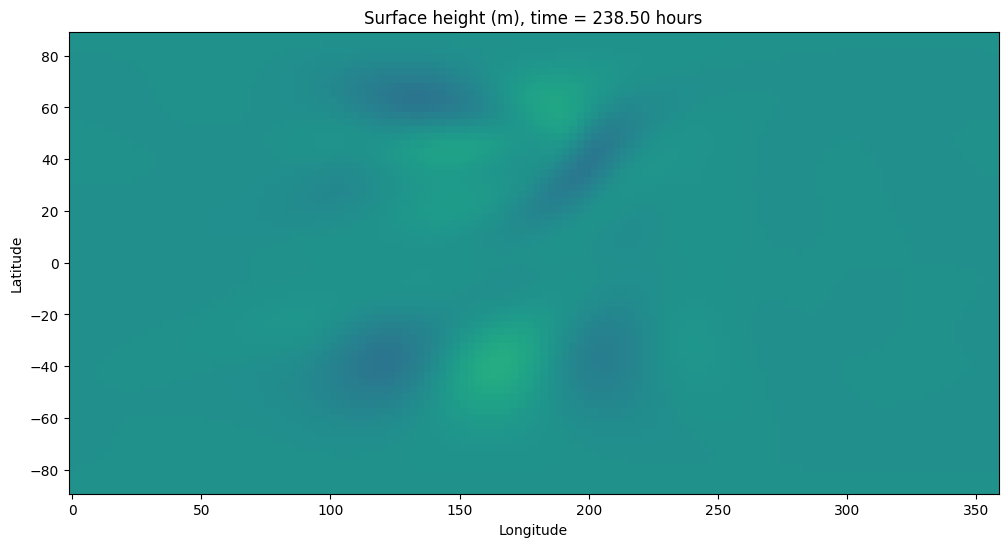

In [15]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [16]:
omega = 2 * np.pi / (1 * day)
radius_earth = 6.37122e3 * kilometer
H_0 = 4*kilometer
g = 9.81 * meter / second**2

def get_speed_for_longitude_and_wavenumber(longitude, k):
  beta = 2*omega*np.cos(longitude)/radius_earth
  f_0 = 2*omega*np.sin(longitude)
  # Excluding l because we're just interested in east/west
  expected_speed = -beta/(k**2+f_0**2/(g*H_0))
  return expected_speed


In [119]:
longitude = np.pi / 4
# Using the distance the wave has traveled as the wavenumber
wavenumber = 1/(8.5*2*day)
print(get_speed_for_longitude_and_wavenumber(longitude, wavenumber), "m/s expected speed")


-22.016529889583225 m/s expected speed


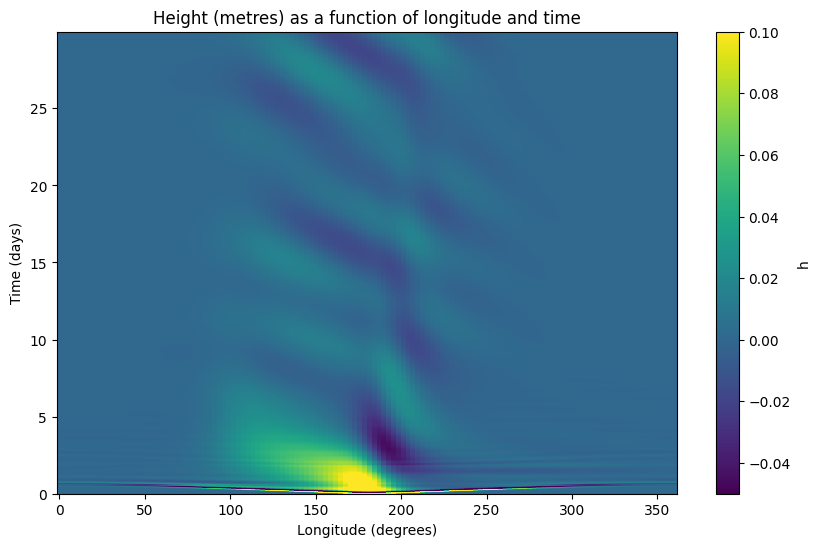

In [120]:
lat_index = int((90+45)/180*Ntheta)
H = h_save[:, :, lat_index]

lon = np.linspace(0, 360, H.shape[1])

plt.figure(figsize=(10,6))
plt.pcolormesh(lon, np.array(t_save) / day, H, vmin=-0.05, vmax=0.1)
plt.xlabel("Longitude (degrees)")
plt.ylabel("Time (days)")
plt.title(f"Height (metres) as a function of longitude and time")
plt.colorbar(label="h")
plt.show()

In [115]:
sampling_rate = 10

day_thirteen = int(stop_sim_time/timestep/sampling_rate * 13/30)
day_fifteen = int(stop_sim_time/timestep/sampling_rate * 15/30)
x_indexes_traveled = np.argmax(H[day_fifteen,:]) - np.argmax(H[day_thirteen,:])
degrees_traveled = x_indexes_traveled * 360 / Nphi
print(degrees_traveled / 2, "degrees per day")
metres_traveled = degrees_traveled * R *2* np.pi / 360 * math.cos(45)
print(metres_traveled / (2 * day), "metres per second")

-12.65625 degrees per day
-8.55690777875911 metres per second


I've extended the time of the simulation to 30 days to allow the initial wave to fully dissipate. In the graph above, we can see the initial wave in the first few days with a fairly large peak, and then a series of rossby waves propogating westward fairly slowly after the initial disturbance has dissipated. Now we can examine the heights of a rossby wave from the graph to approximate the speed. We see that the main disturbance has dissipated by the 10th day, so we look at the velocity of the wave peak from the 13th to the 15th day to see that it travels at roughly 8 metres per second to the west (or 12 degrees per day, which lines up with the graph for validation of the method). We can calculate the theoretical speed through

$$ \dfrac{- β}{k^2+l^2+\dfrac{f_0^2}{gH_0}} $$

Which evaluates to roughly 22 m/s to the west (see three cells up for the calculation). The expected speed is quite a bit faster than the observed speed. Although the expected and observed speed align in direction, the expected speed is about twice that of the observed speed. This may be due to a few reasons. The dedalus script used to generate the simulation relied on some approximations, such as linearizations, which may cause a greater effect as greater timesteps. Furthermore, although there is damping, there is still some interfence from other waves.

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?